# Exploring the radial properties of the hot-ICM temperature

<span style="color:red">This should currently be considered preliminary, as there are some problems with observation selection for spectral generation for some of these large clusters - also our improved background method isn't fully implemented. Also also, we are still using the MCXC defined coordinates</span>

<span style="color:red">**We do not currently make the temperature profile saves available, as I need to create a better file format for them (i.e. FITS based), and they are probably too large for GitHub right now.**</span>

## Import Statements

In [47]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from shutil import rmtree
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 50
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.temperature import min_cnt_proj_temp_prof  
from xga.sas.phot import emosaic
from xga.imagetools.misc import physical_rad_to_pix
from xga.exceptions import NoProductAvailableError
from xga.products import BaseAggregateProfile1D

%matplotlib inline

xga.__version__

'0+unknown'

## Creating Storage Directories

We ensure that the storage directories within which we will store output files from this analysis have been created:

In [56]:
stor_dir = '../../outputs/results/profiles/projected_temperature/'
if not os.path.exists(stor_dir):
    os.makedirs(stor_dir)
    
fig_dir = '../../outputs/figures/profiles/projected_temperature/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
    
# And the same deal for projected metallicity
stor_dir_met = '../../outputs/results/profiles/projected_metallicity/'
if not os.path.exists(stor_dir_met):
    os.makedirs(stor_dir_met)
    
fig_dir_met = '../../outputs/figures/profiles/projected_metallicity/'
if not os.path.exists(fig_dir_met):
    os.makedirs(fig_dir_met)

## Define the cosmology

We make use of a concordance flat LambdaCDM cosmology during the course of this analysis:

In [2]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading the sample file

We read in the sample file to get the information we need to set up an XGA ClusterSample:

In [3]:
samp = pd.read_csv('../../outputs/results/ltr_r500_metfree_pipeline_results.csv')
rad_hist = pd.read_csv('../../outputs/results/ltr_r500_metfree_radii_history.csv')

samp = samp[~np.isnan(samp['r500'])]

temp_samp = samp.merge(rad_hist)
samp = samp[temp_samp['converged'].values]
samp.reset_index(drop=True, inplace=True)
samp

name          ra        dec  redshift         r500    Tx500  \
0    LoVoCCS-4B   10.451487  -9.460007    0.0555  1144.764889  5.55319   
1     LoVoCCS-5  303.157313 -56.845978    0.0556  1119.049232  5.35600   
2     LoVoCCS-7  330.480000 -59.950000    0.0980  1149.344414  5.88148   
3     LoVoCCS-9   67.830487 -61.447401    0.0589  1209.871886  6.80800   
4    LoVoCCS-10  194.840000  -4.190000    0.0845  1129.503907  5.57022   
5    LoVoCCS-13   49.490000 -44.240000    0.0752   944.951945  4.04929   
6    LoVoCCS-15  351.330000 -12.130000    0.0852   892.237349  3.69158   
7    LoVoCCS-18  194.671250  -1.756944    0.0845  1043.615449  4.88707   
8    LoVoCCS-22  308.694130 -35.823600    0.0894  1010.640028  4.61534   
9    LoVoCCS-24  342.487500 -64.429444    0.0940  1039.992188  4.87439   
10   LoVoCCS-26  333.635833 -10.371667    0.0980  1027.877810  4.78511   
11   LoVoCCS-29   10.540000 -28.540000    0.1082  1024.815095  4.79825   
12   LoVoCCS-31  332.580000 -12.180000    0.0846  1096.053610  5.36953   
13   LoVoCCS-35  341.577500 -52.729444    0.0965  1032.596125  4.84213   
14  LoVoCCS-41A  202.707467  -1.862240    0.0852   953.590102  4.14885   
15  LoVoCCS-41B  202.793430  -1.726838    0.0852   801.408785  3.07467   
16   LoVoCCS-42  328.538333 -57.855278    0.0760   998.686575  4.51827   
17   LoVoCCS-45   26.259583 -53.013889    0.1168  1168.463593  6.08646   
18  LoVoCCS-46A  335.987686  -1.583249    0.0906   960.384159  4.21831   
19  LoVoCCS-46C  335.948893  -1.649615    0.0906   952.474030  4.15804   
20  LoVoCCS-48A  194.287408 -17.409460    0.0473   943.562781  3.93382   
21  LoVoCCS-48B  194.455488 -17.273181    0.0495   475.031922  1.18218   
22   LoVoCCS-49  175.350000 -12.270000    0.1195   856.791625  3.54499   
23   LoVoCCS-51  334.502097 -65.181454    0.0951   953.090335  4.17984   
24   LoVoCCS-58  323.568242 -13.438889    0.0897   702.921474  2.48042   
25  LoVoCCS-60A  334.572621  -3.825365    0.0901  1077.486205  5.17927   
26  LoVoCCS-60B  334.666651  -3.779926    0.0901  1082.159431  5.75661   
27   LoVoCCS-61  336.521149  17.365823    0.1072  1141.605952  5.80417   
28   LoVoCCS-63  229.080000   0.100000    0.1181  1003.819878  4.67081   
29  LoVoCCS-66A  328.091327 -19.546198    0.0943   950.324035  3.98559   
30  LoVoCCS-66B  328.032613 -19.722221    0.0943   951.079752  4.15005   
31   LoVoCCS-74  332.347083 -51.815000    0.1065   959.469055  4.27019   
32   LoVoCCS-75  346.809618 -15.223940    0.1110   822.726132  3.27395   
33   LoVoCCS-76  348.250000 -21.630000    0.0871   828.233379  3.24279   
34   LoVoCCS-80   52.160000 -55.710000    0.0853  1063.442310  5.01590   
35   LoVoCCS-85   12.350000 -29.524444    0.1084   908.546789  3.88983   
36   LoVoCCS-89  348.079888 -21.504098    0.1108  1004.542719  4.63548   
37   LoVoCCS-90  227.862104   6.349277    0.0817   918.403058  3.90106   
38  LoVoCCS-93B   96.687844 -54.539092    0.0506   958.970580  4.62479   
39   LoVoCCS-94  191.149659 -11.993136    0.0963   938.506490  4.09309   
40   LoVoCCS-98  358.560000 -10.410000    0.0765   903.258219  3.74696   
41  LoVoCCS-119  125.258665   7.863501    0.1100   755.394004  2.81596   
42  LoVoCCS-121   52.466189 -52.580728    0.0624   777.679215  2.93458   
43  LoVoCCS-123  193.670000 -29.220000    0.0544   941.234255  3.94555   
44  LoVoCCS-131  137.651250 -10.581111    0.0916   988.541253  4.44336   
45  LoVoCCS-134  329.604682 -60.413676    0.0750   840.176608  3.43585   

      Tx500-    Tx500+  Lx500_0.5-2.0  Lx500_0.5-2.0-  Lx500_0.5-2.0+  \
0   0.049256  0.049231   6.827098e+43    2.376048e+42    1.631782e+42   
1   0.044514  0.044392   1.603958e+44    7.309935e+42    6.470704e+42   
2   0.063561  0.063588   3.036659e+44    1.317301e+42    9.510817e+41   
3   0.045162  0.040867   1.551936e+44    2.095797e+42    2.155744e+42   
4   0.089904  0.089403   3.010015e+44    1.873288e+42    1.386844e+42   
5   0.010001  0.008223   2.487713e+44    2.572661e+41    3.935470e+41   
6   0.009654  0.00965

## Set up an XGA ClusterSample

We set up an XGA ClusterSample to help us manage all the data and analyse the objects. 

<span style="color:red">The threshold for an observation being determined as relevant is set to 70% of the $R_{500}$ being on a particular observation.</span> 

In [ ]:
# This one had that fucking 'None has no usable attribute error'
# samp = samp[~samp.index.isin([65])]

In [4]:
ra = samp['ra'].values
dec = samp['dec'].values
name = samp['name'].values
z = samp['redshift'].values
r500 = Quantity(samp['r500'].values, 'kpc')

srcs = ClusterSample(ra, dec, z, name, r500=r500, use_peak=False, clean_obs=True, clean_obs_reg='r500', 
                     clean_obs_threshold=0.7, cosmology=cosmo, load_fits=True)

Setting up Galaxy Clusters: 100%|██████████| 46/46 [04:10<00:00,  5.46s/it]
/tmp/local/35931180/ipykernel_33728/298872034.py:7: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); LoVoCCS-4B, LoVoCCS-5, LoVoCCS-9
  srcs = ClusterSample(ra, dec, z, name, r500=r500, use_peak=False, clean_obs=True, clean_obs_reg='r500',
/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/samples/extended.py:279: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


## Removing problematic observations

In [ ]:
# srcs['LoVoCCS-40'].disassociate_obs({'0502671101': ['mos2']})

## Generating projected temperature and metallicity profiles

### Minimum counts = 1500

In [5]:
rads = min_cnt_proj_temp_prof(srcs, srcs.r500, Quantity(1500, 'ct'), one_rmf=False, freeze_met=False)

/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for LoVoCCS-48B cannot be created, the data quality is too low. As such a set of four annuli will be returned
  rads, cnts, ma = _cnt_bins(src, out_rad_vals[src_ind], min_cnt, min_width, lo_en, hi_en, psf_corr=psf_corr,
/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for LoVoCCS-89 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  rads, cnts, ma = _cnt_bins(src, out_rad_vals[src_ind], min_cnt, min_width, lo_en, hi_en, psf_corr=psf_corr,
Generating products of type(s) annular spectrum set components: 100%|██████████| 2803/2803 [9:03:01<00:00, 11.62s/it]   
Running XSPEC Fits: 100%|██████████| 683/683 [2:25:37<00:00, 12.79s/it]  
/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/sit

We (temporarily) store the measured projected temperatures/metallicities (and the central position/width of their annular bins) in csvs, indicating in the name which minimum count was used. This will later be replaced by simply including XGA output profile files in the repository, but we first need to create a better way of outputting those profiles:

In [41]:
for rad_ind, rad in enumerate(rads):
    src = srcs[rad_ind]
    try:
        t_prof = src.get_proj_temp_profiles(radii=rad)
        
        data = np.concatenate([t_prof.values.value[..., None], t_prof.values_err.value[..., None], 
                               t_prof.radii.value[..., None], t_prof.radii_err.value[..., None]], axis=1)
        
        tp_df = pd.DataFrame(data, columns=['Tx', 'Tx_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_tproj_min1500ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir + file_name)
        
        met_prof = src.get_combined_profiles('1d_proj_metallicity', radii=rad)
        
        data = np.concatenate([met_prof.values.value[..., None], met_prof.values_err.value[..., None], 
                               met_prof.radii.value[..., None], met_prof.radii_err.value[..., None]], axis=1)
        
        metp_df = pd.DataFrame(data, columns=['met', 'met_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_metproj_min1500ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir_met + file_name)
        
    except NoProductAvailableError:
        pass

### Minimum counts = 3000

In [6]:
rads_3000 = min_cnt_proj_temp_prof(srcs, srcs.r500, Quantity(3000, 'ct'), one_rmf=False, freeze_met=False)

/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for LoVoCCS-48B cannot be created, the data quality is too low. As such a set of four annuli will be returned
  rads, cnts, ma = _cnt_bins(src, out_rad_vals[src_ind], min_cnt, min_width, lo_en, hi_en, psf_corr=psf_corr,
/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for LoVoCCS-58 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  rads, cnts, ma = _cnt_bins(src, out_rad_vals[src_ind], min_cnt, min_width, lo_en, hi_en, psf_corr=psf_corr,
/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for LoVoCCS-89 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  rad

We (temporarily) store the measured projected temperatures (and the central position/width of their annular bins) in csvs, indicating in the name which minimum count was used. This will later be replaced by simply including XGA output profile files in the repository, but we first need to create a better way of outputting those profiles:

In [45]:
for rad_ind, rad in enumerate(rads_3000):
    src = srcs[rad_ind]
    try:
        t_prof = src.get_proj_temp_profiles(radii=rad)
        
        data = np.concatenate([t_prof.values.value[..., None], t_prof.values_err.value[..., None], 
                               t_prof.radii.value[..., None], t_prof.radii_err.value[..., None]], axis=1)
        
        tp_df = pd.DataFrame(data, columns=['Tx', 'Tx_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_tproj_min3000ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir + file_name)
        
        met_prof = src.get_combined_profiles('1d_proj_metallicity', radii=rad)
        
        data = np.concatenate([met_prof.values.value[..., None], met_prof.values_err.value[..., None], 
                               met_prof.radii.value[..., None], met_prof.radii_err.value[..., None]], axis=1)
        
        metp_df = pd.DataFrame(data, columns=['met', 'met_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_metproj_min3000ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir_met + file_name)
        
    except NoProductAvailableError:
        pass

### Minimum counts = 4000

In [10]:
rads_4000 = min_cnt_proj_temp_prof(srcs, srcs.r500, Quantity(4000, 'ct'), one_rmf=False, freeze_met=False)

/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for LoVoCCS-48B cannot be created, the data quality is too low. As such a set of four annuli will be returned
  rads, cnts, ma = _cnt_bins(src, out_rad_vals[src_ind], min_cnt, min_width, lo_en, hi_en, psf_corr=psf_corr,
/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for LoVoCCS-58 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  rads, cnts, ma = _cnt_bins(src, out_rad_vals[src_ind], min_cnt, min_width, lo_en, hi_en, psf_corr=psf_corr,
/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for LoVoCCS-66A cannot be created, the data quality is too low. As such a set of four annuli will be returned
  ra

We (temporarily) store the measured projected temperatures (and the central position/width of their annular bins) in csvs, indicating in the name which minimum count was used. This will later be replaced by simply including XGA output profile files in the repository, but we first need to create a better way of outputting those profiles:

In [46]:
for rad_ind, rad in enumerate(rads_4000):
    src = srcs[rad_ind]
    try:
        t_prof = src.get_proj_temp_profiles(radii=rad)
        
        data = np.concatenate([t_prof.values.value[..., None], t_prof.values_err.value[..., None], 
                               t_prof.radii.value[..., None], t_prof.radii_err.value[..., None]], axis=1)
        
        tp_df = pd.DataFrame(data, columns=['Tx', 'Tx_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_tproj_min4000ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir + file_name)
        
        met_prof = src.get_combined_profiles('1d_proj_metallicity', radii=rad)
        
        data = np.concatenate([met_prof.values.value[..., None], met_prof.values_err.value[..., None], 
                               met_prof.radii.value[..., None], met_prof.radii_err.value[..., None]], axis=1)
        
        metp_df = pd.DataFrame(data, columns=['met', 'met_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_metproj_min4000ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir_met + file_name)
        
    except NoProductAvailableError:
        pass

## Visualising different minimum count-rate profiles on the same figure

We create and save visualisations of the projected temperature and metallicity profiles, with all of our attempts at measuring their profiles (i.e. the different minimum count rates) plotted on the same axis.

In [50]:
forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp)), 
         'xminor': FuncFormatter(lambda inp, _: '{:g}'.format(inp)), 
         'ymajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp)),
         'yminor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}

### Projected Temperature

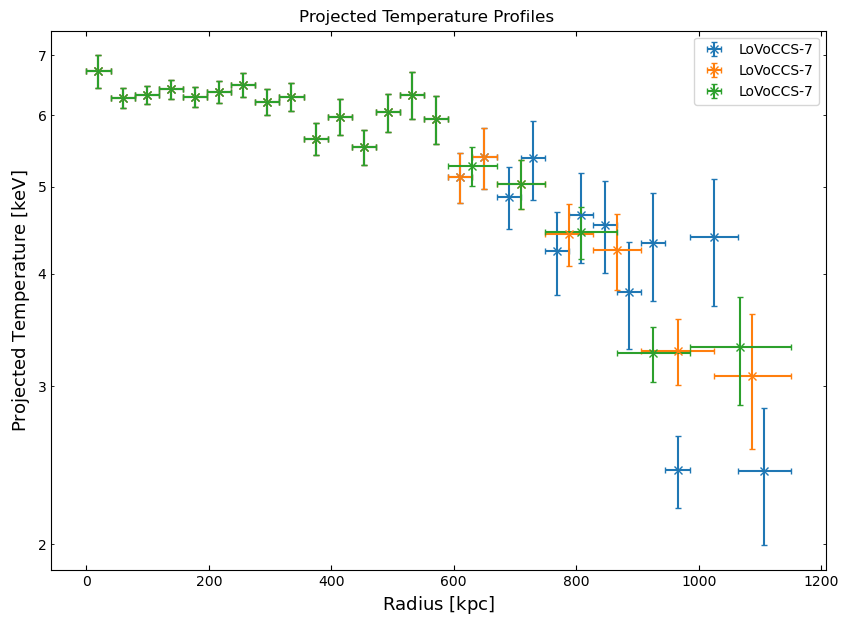

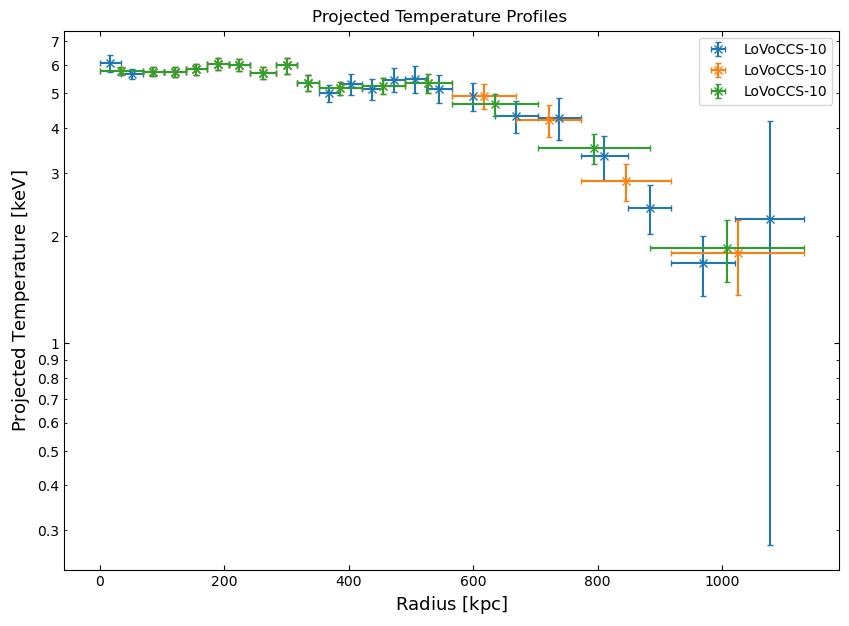

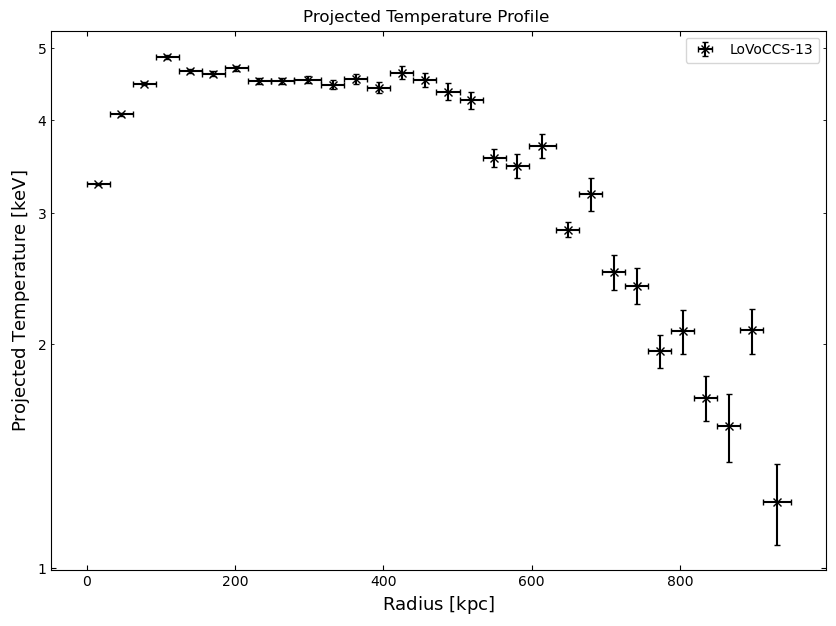

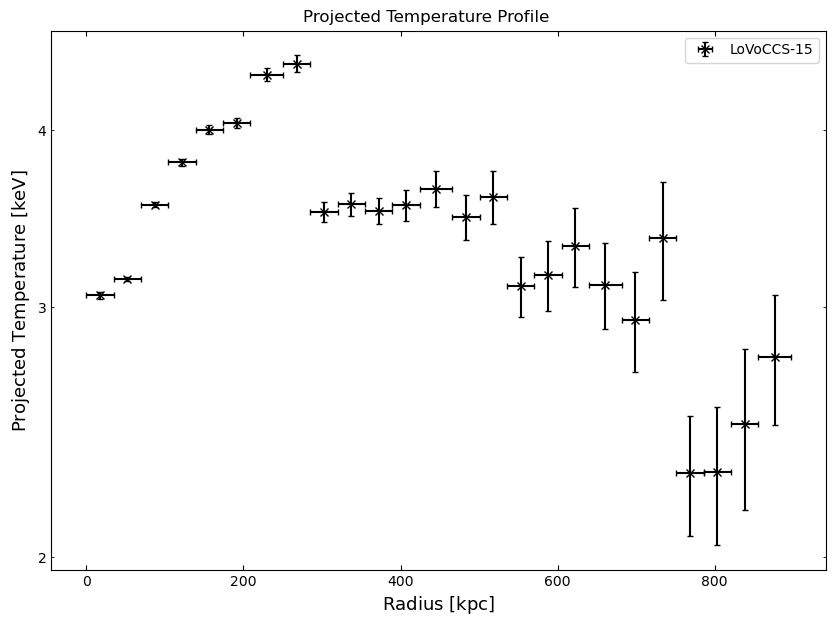

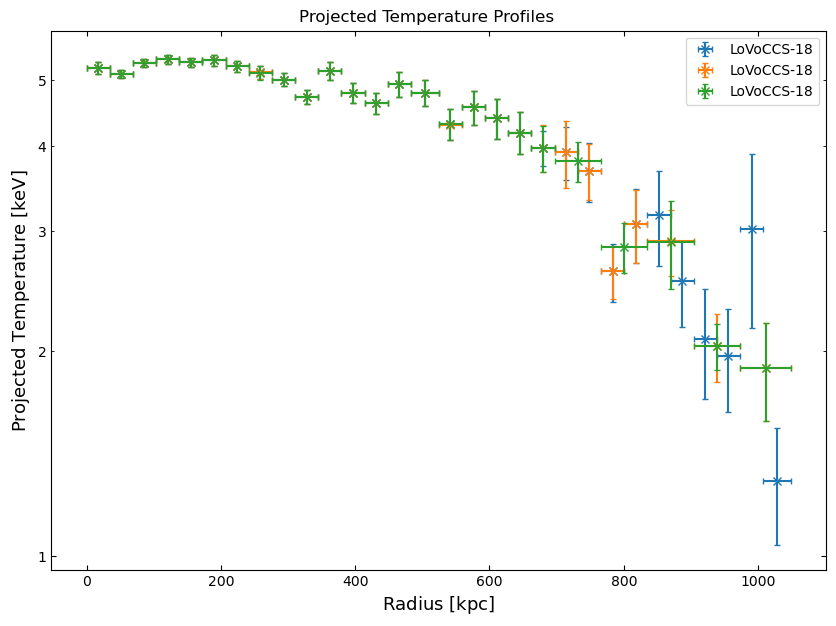

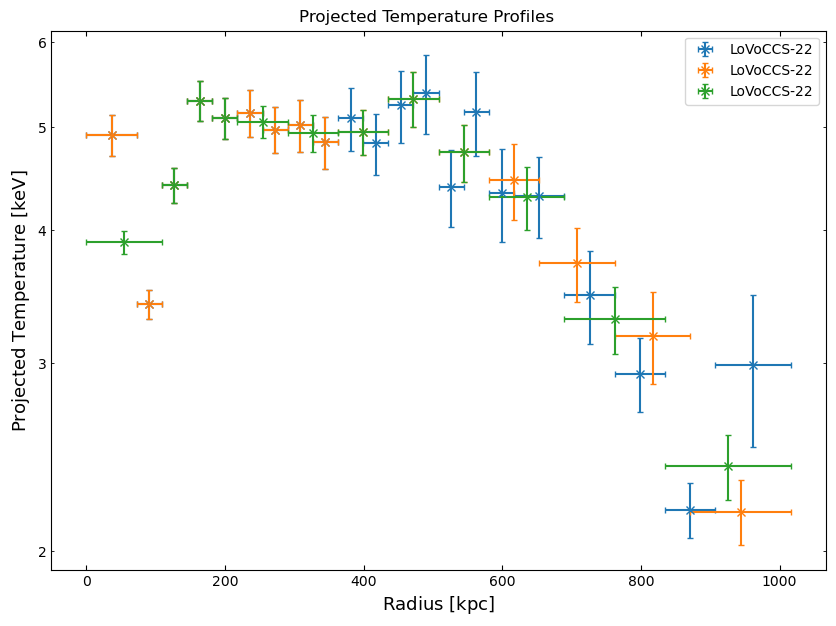

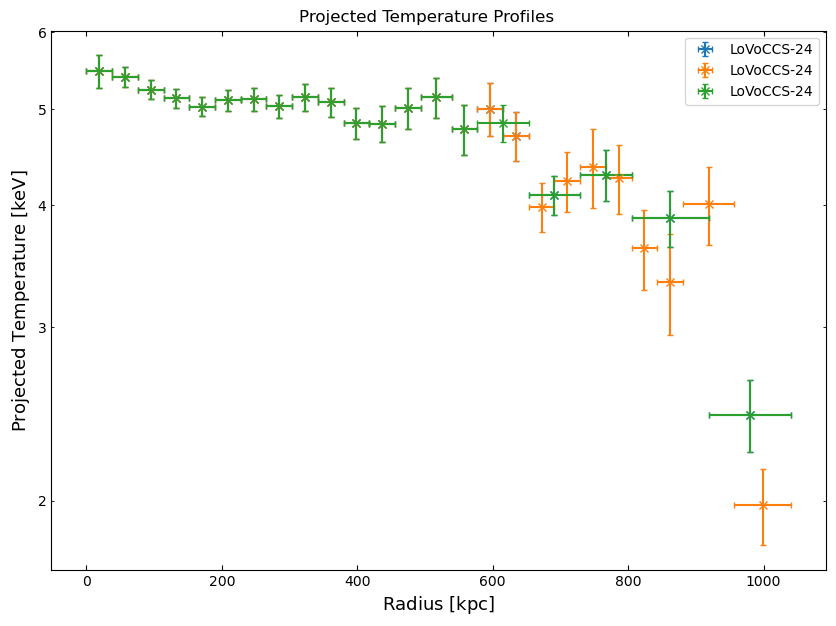

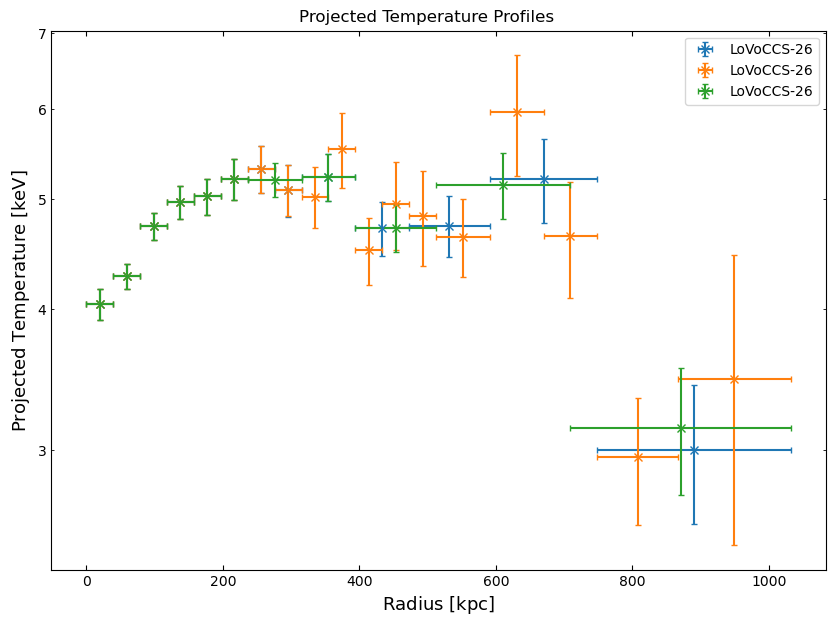

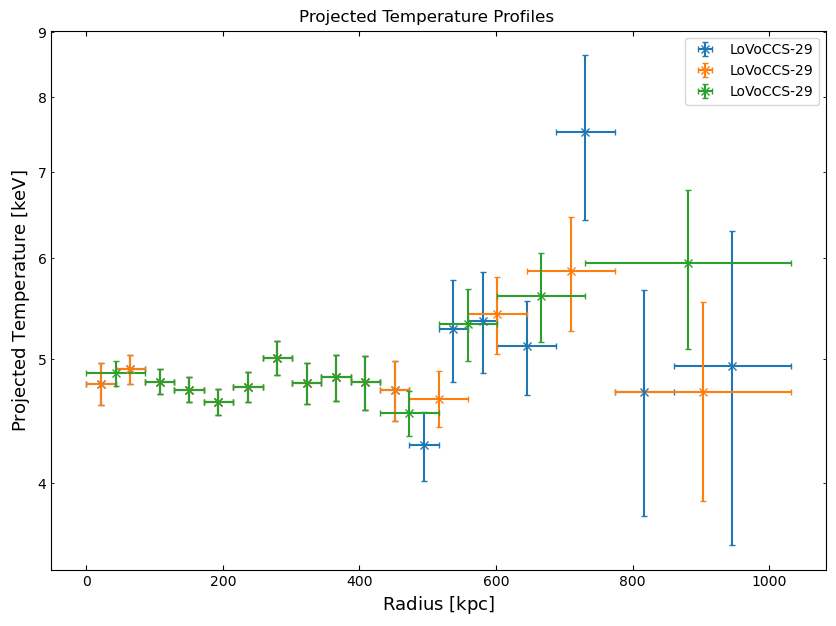

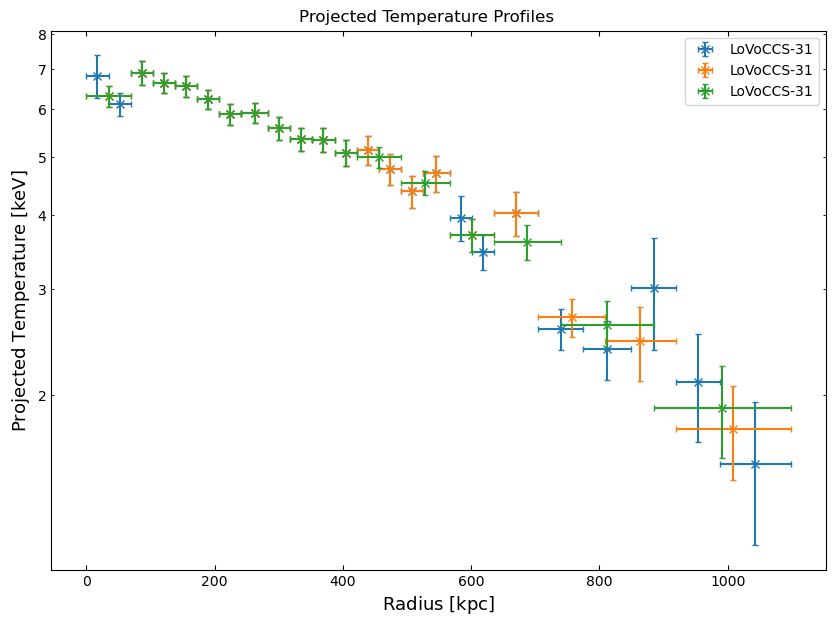

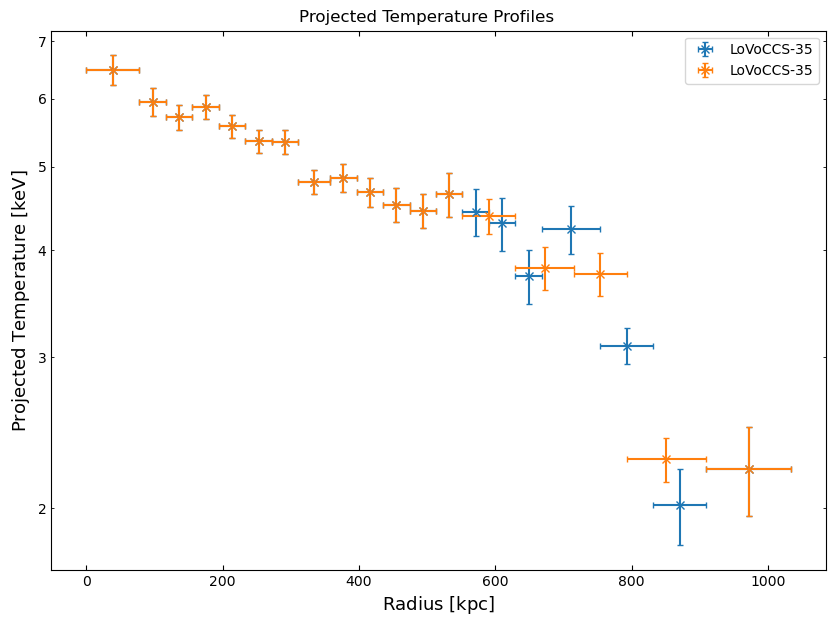

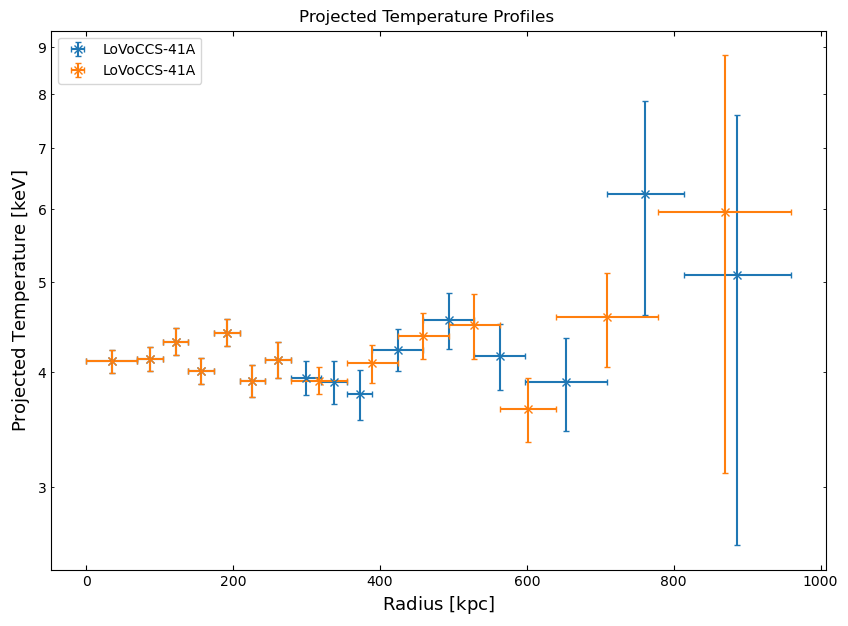

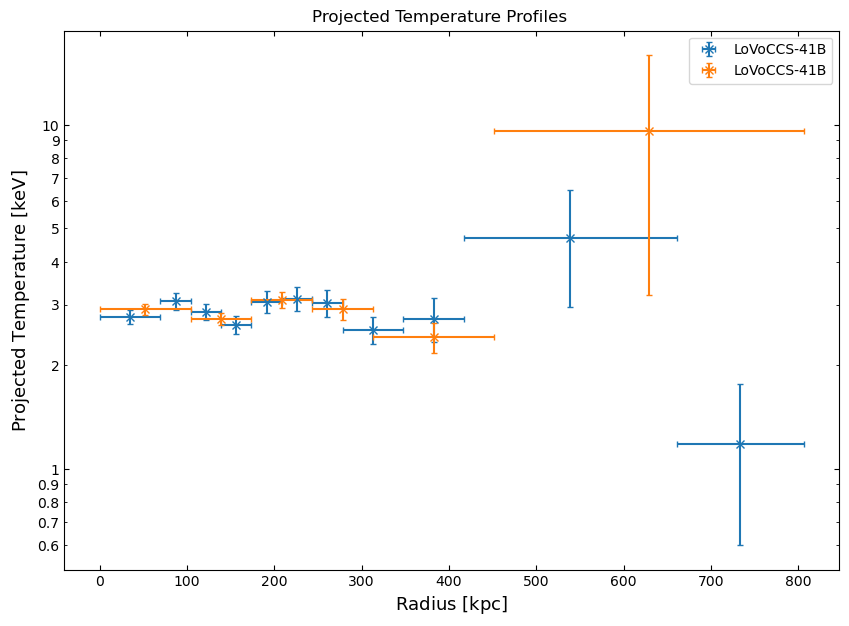

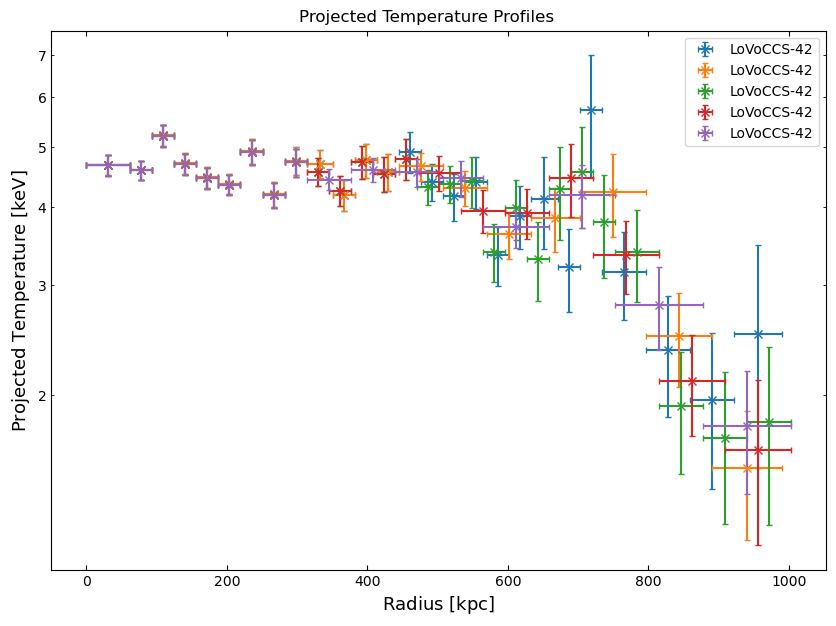

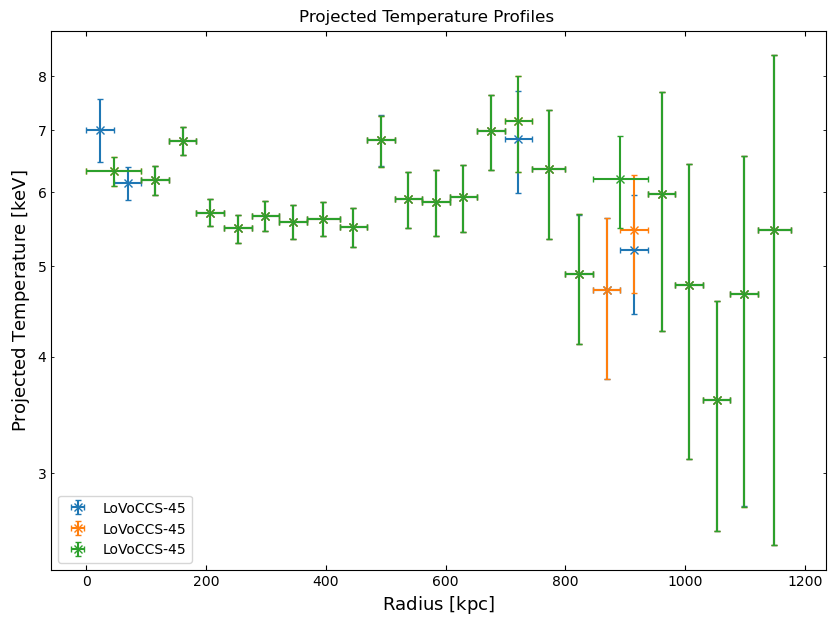

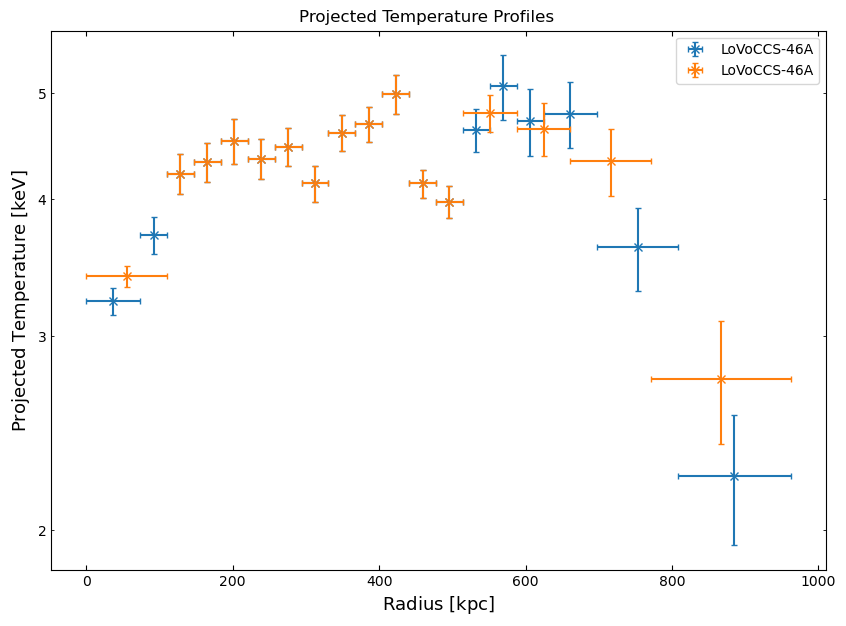

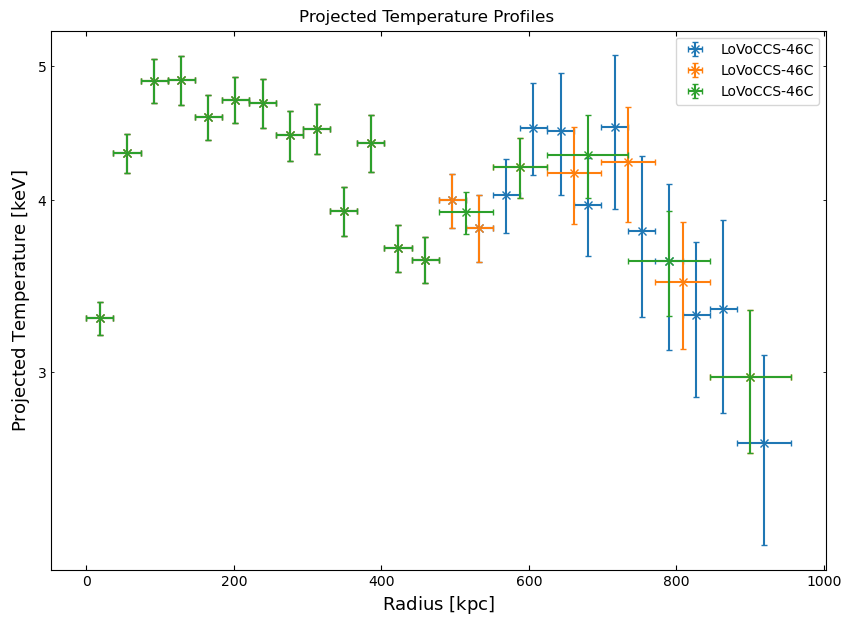

LoVoCCS-48A


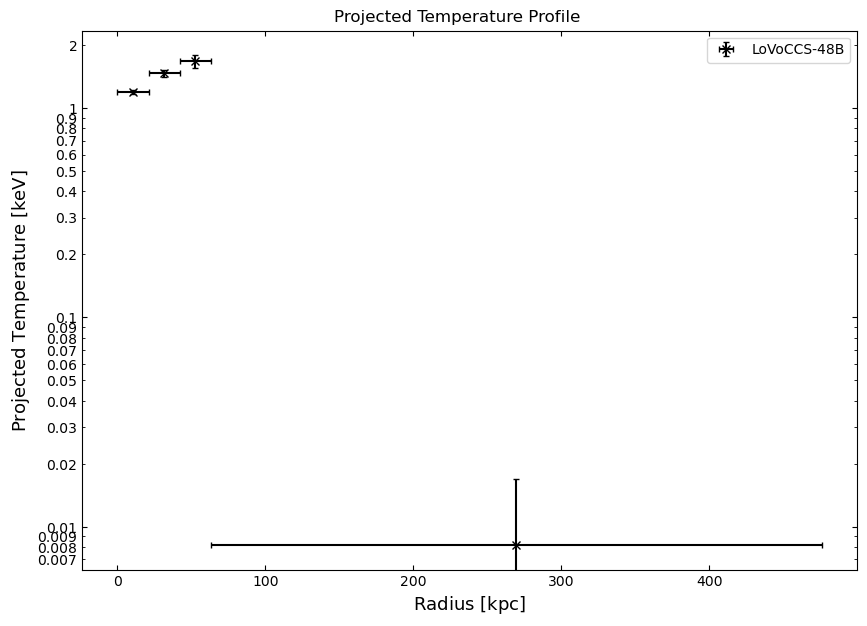

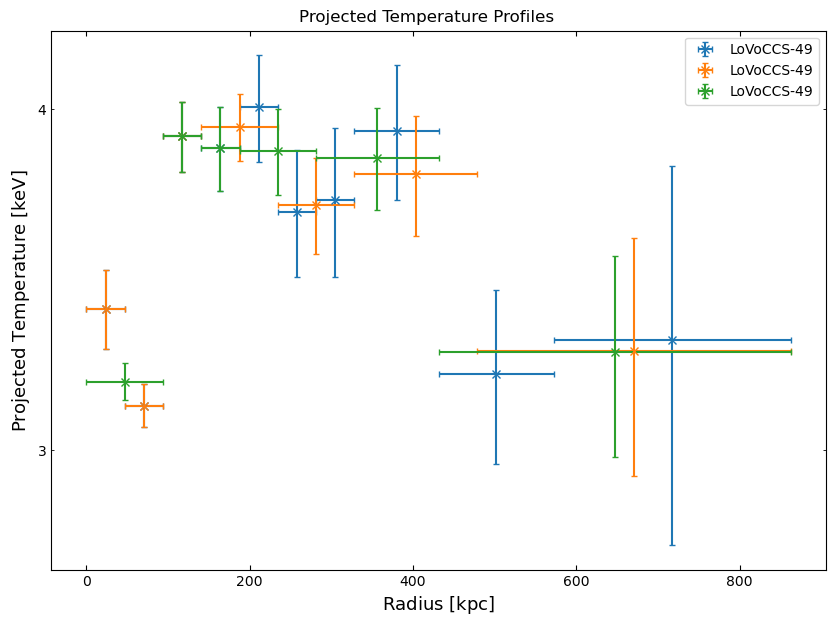

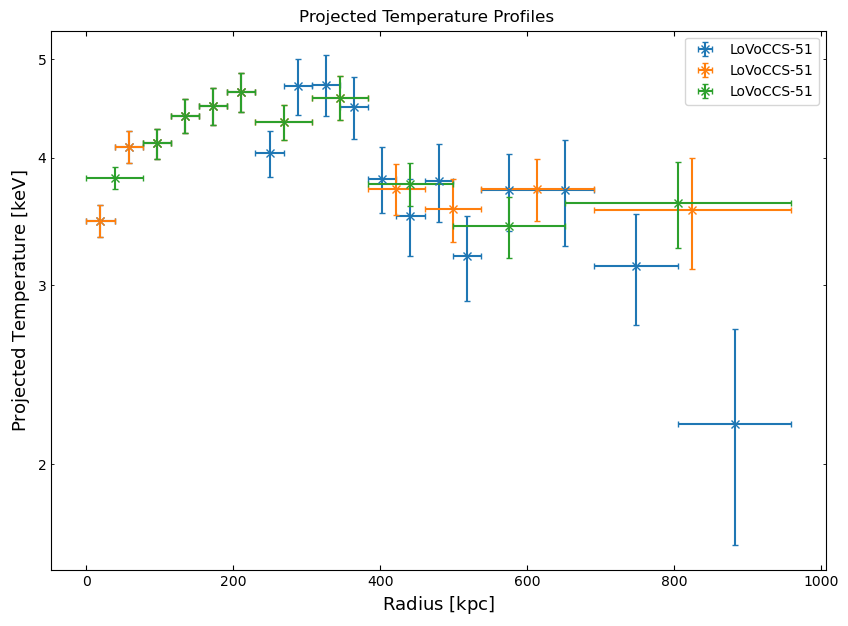

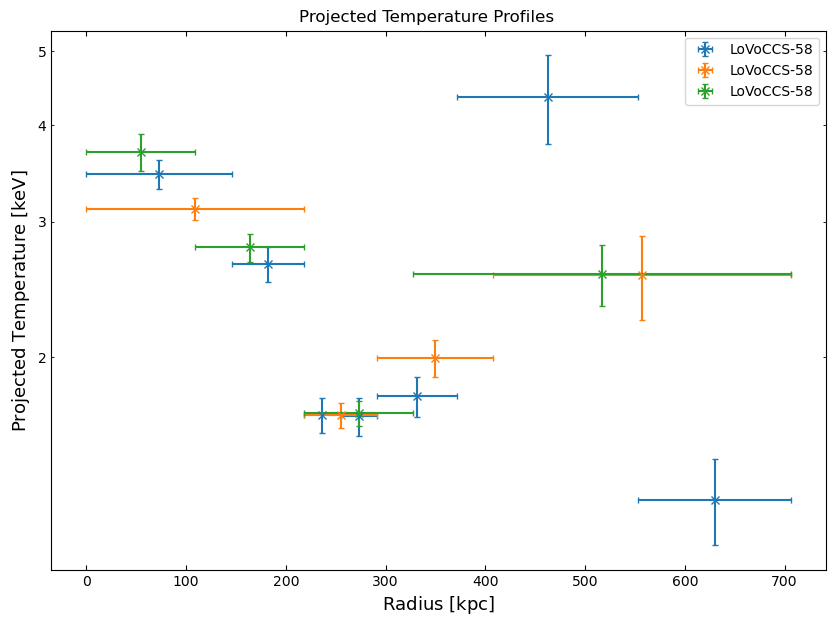

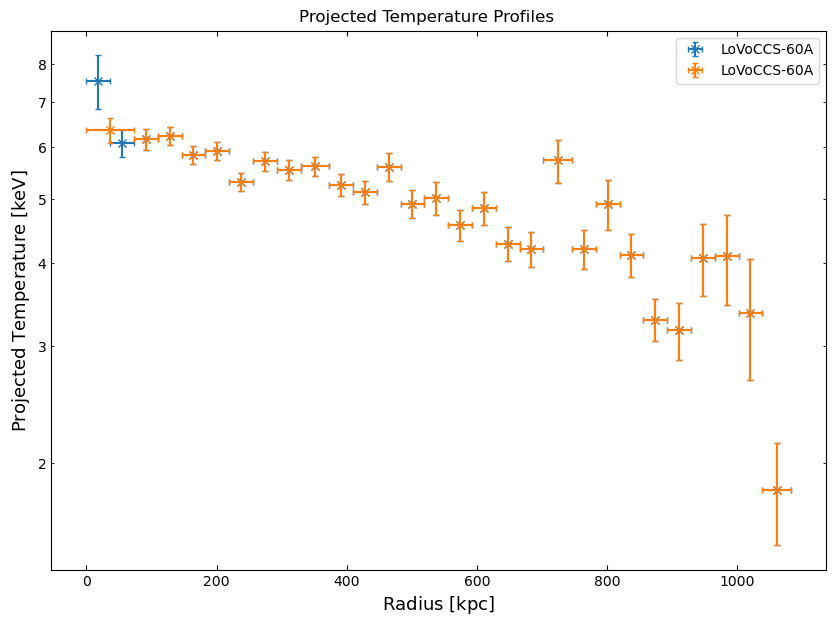

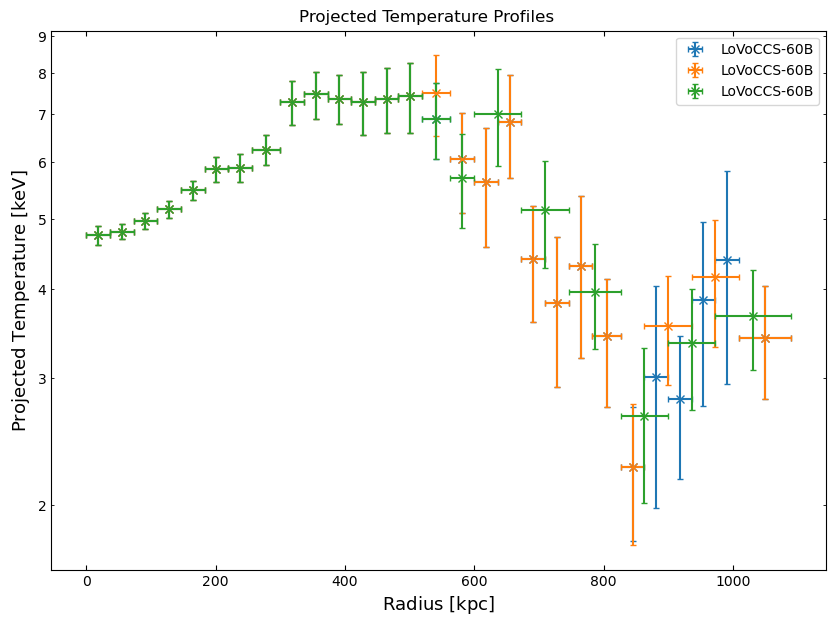

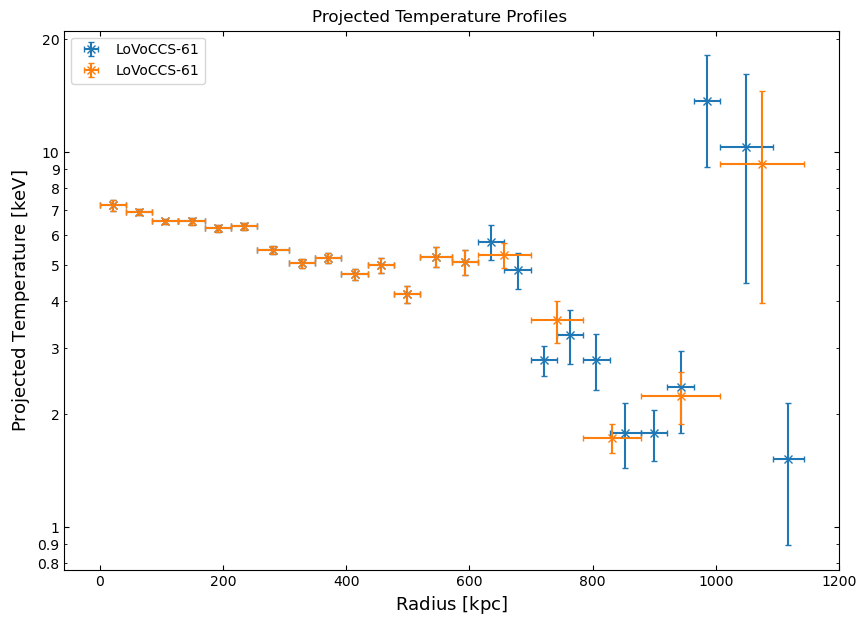

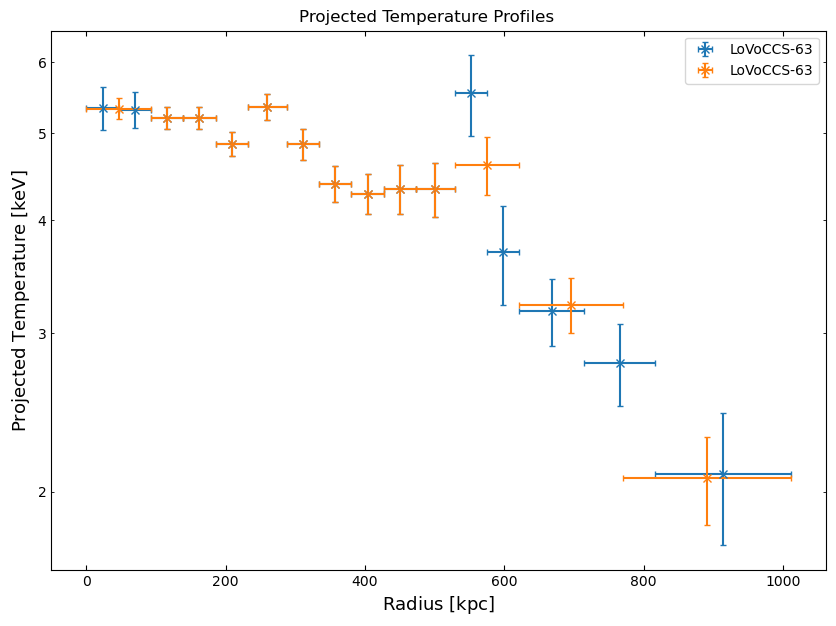

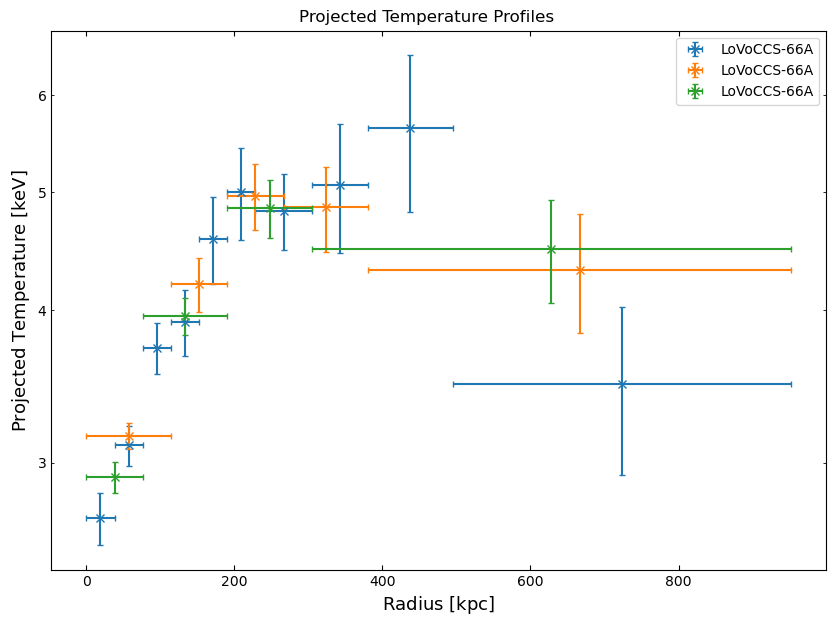

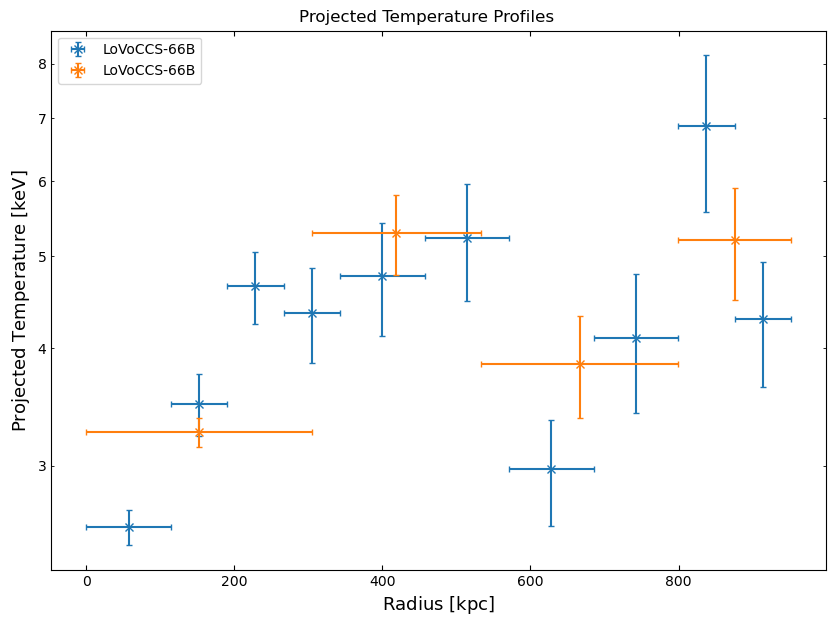

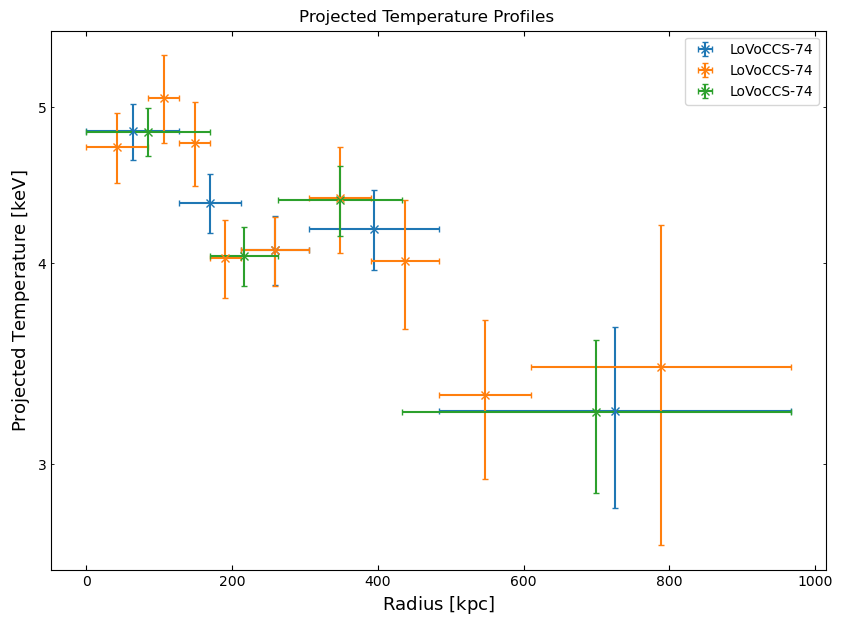

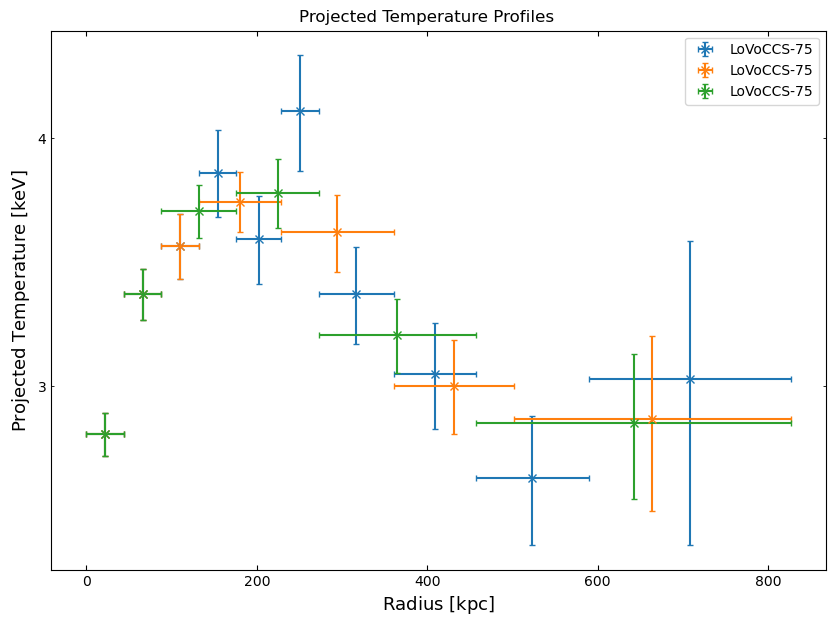

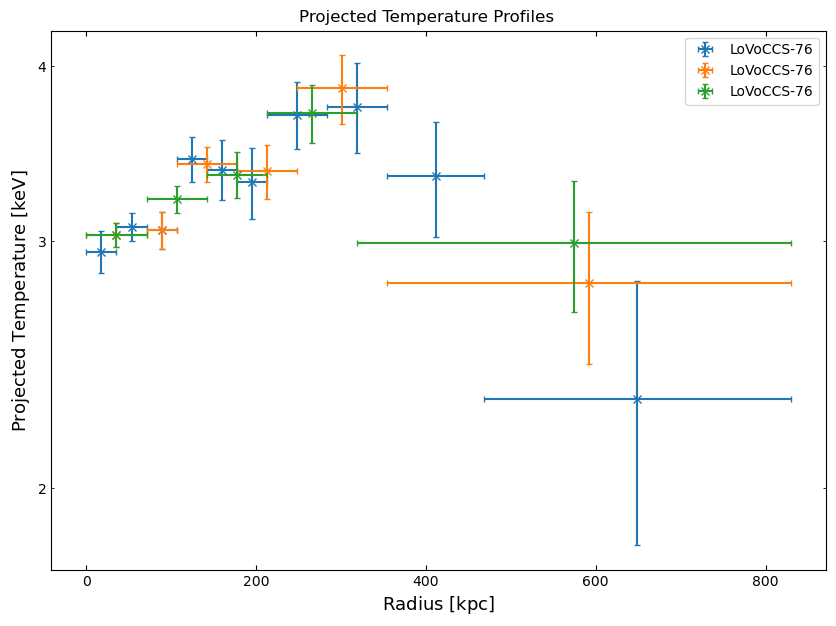

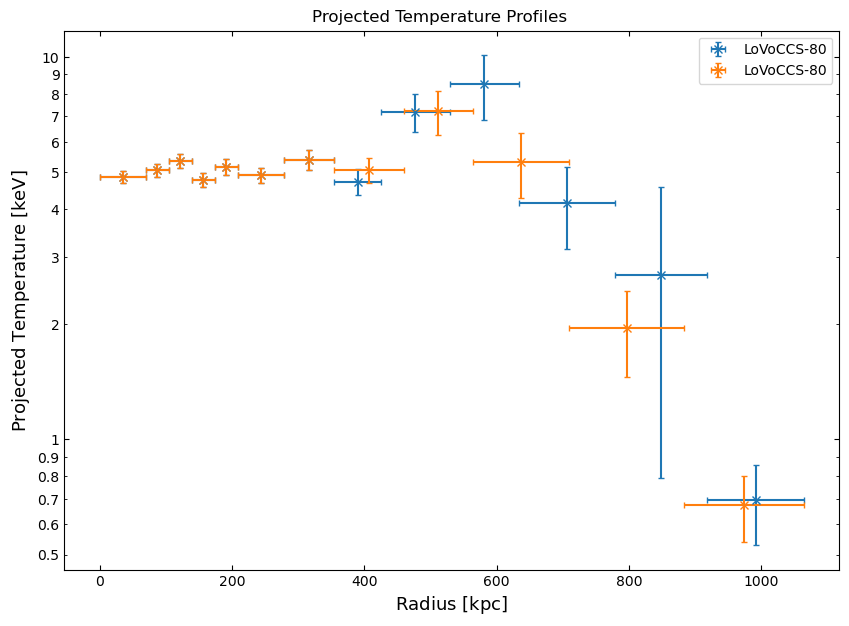

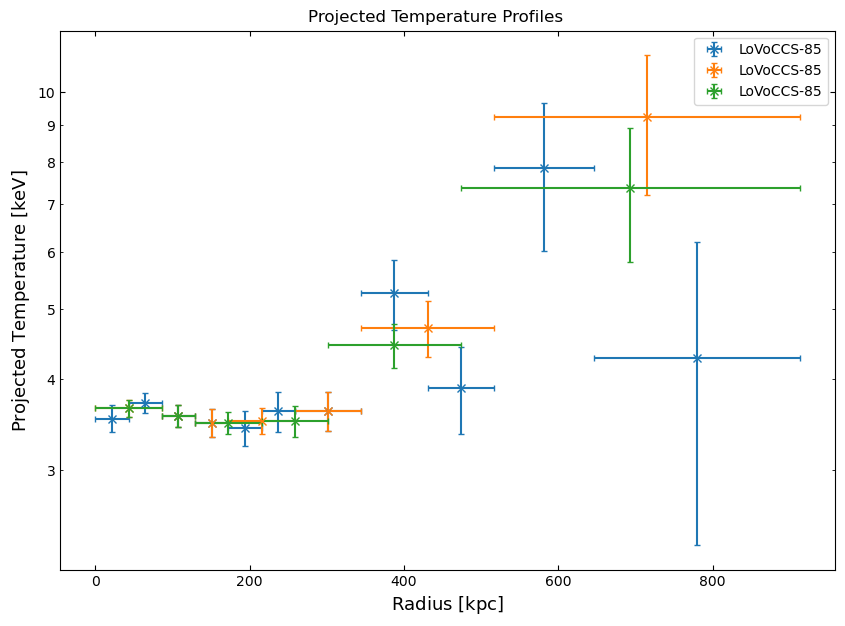

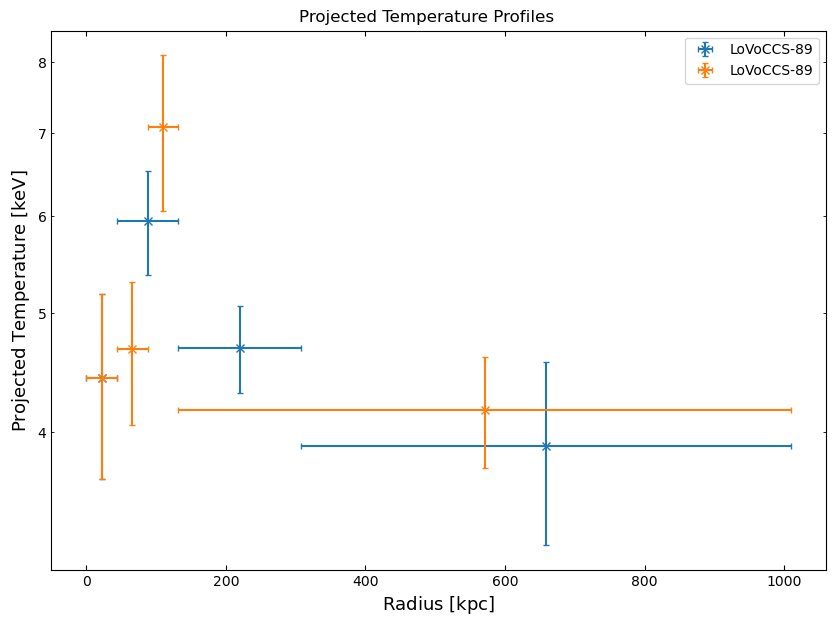

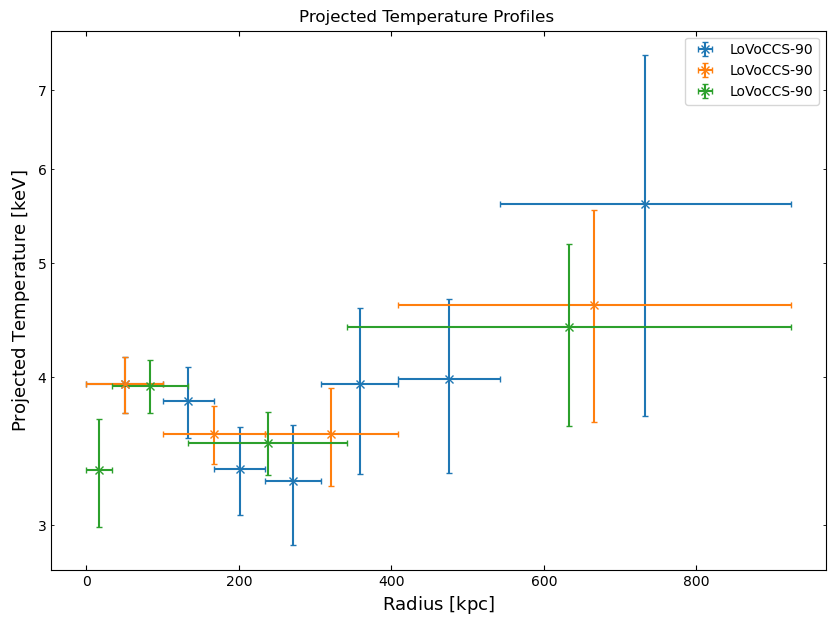

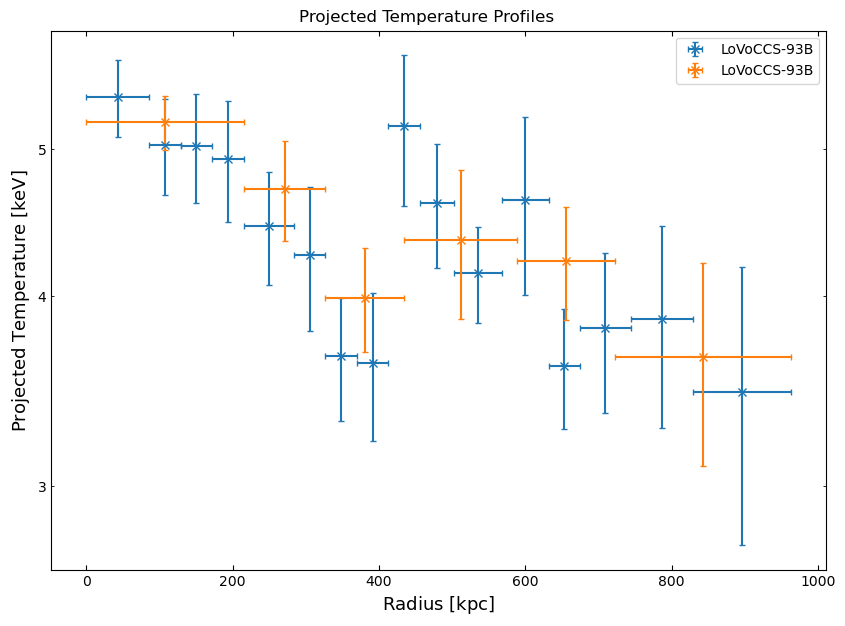

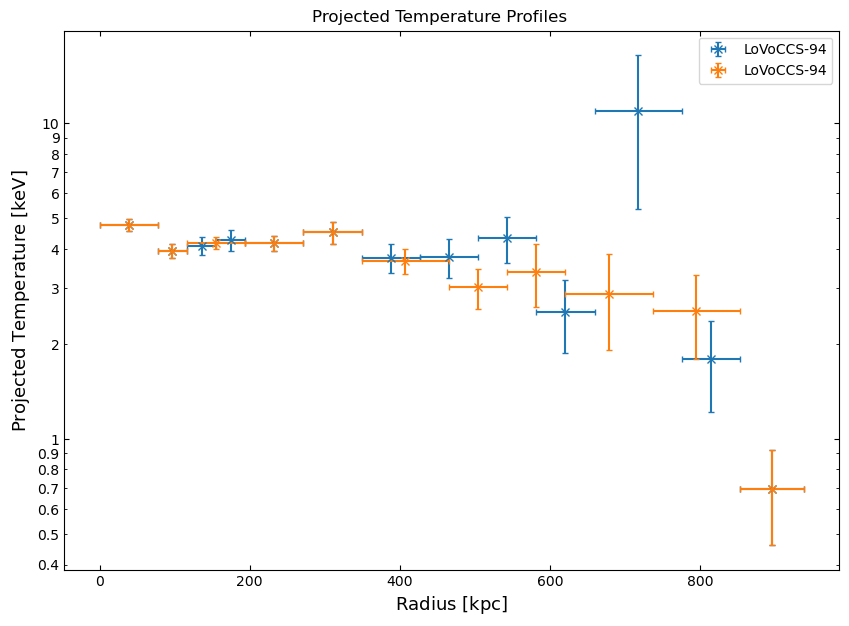

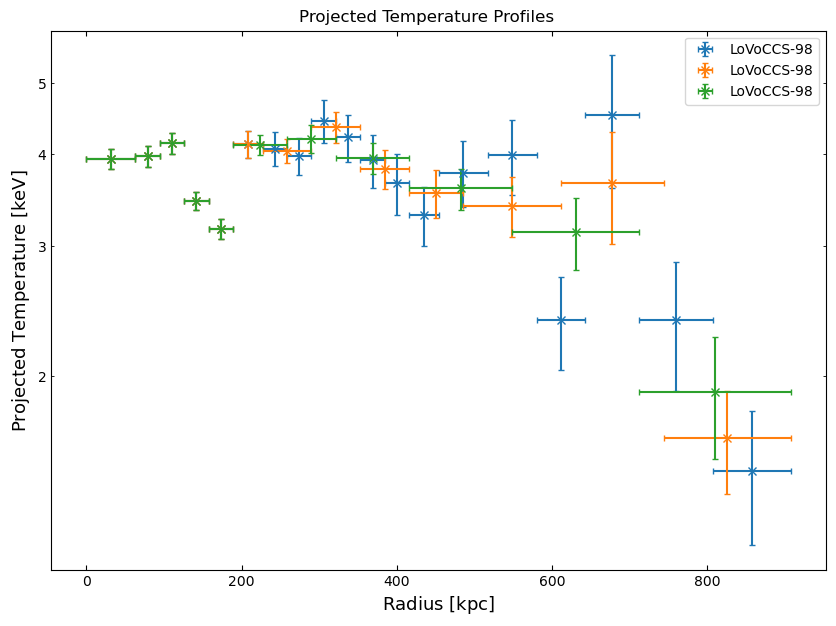

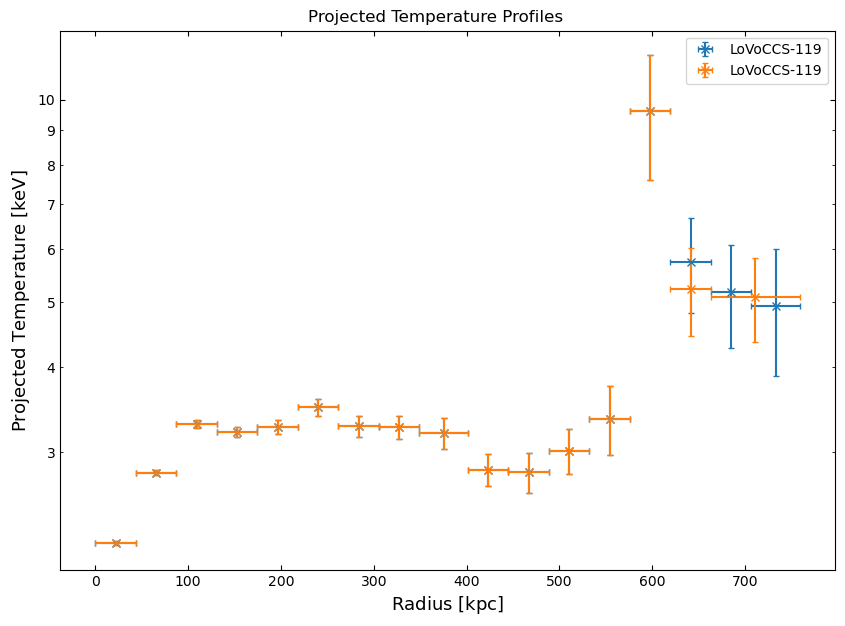

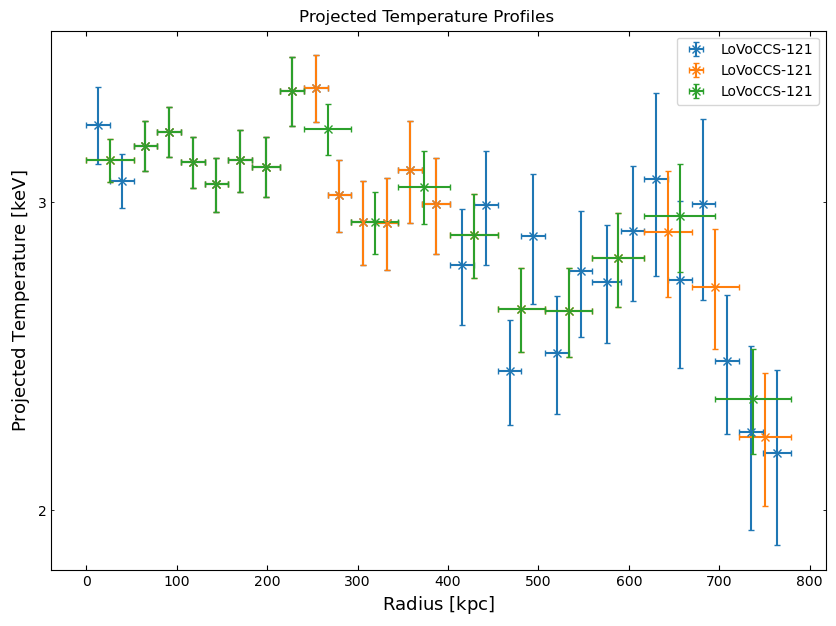

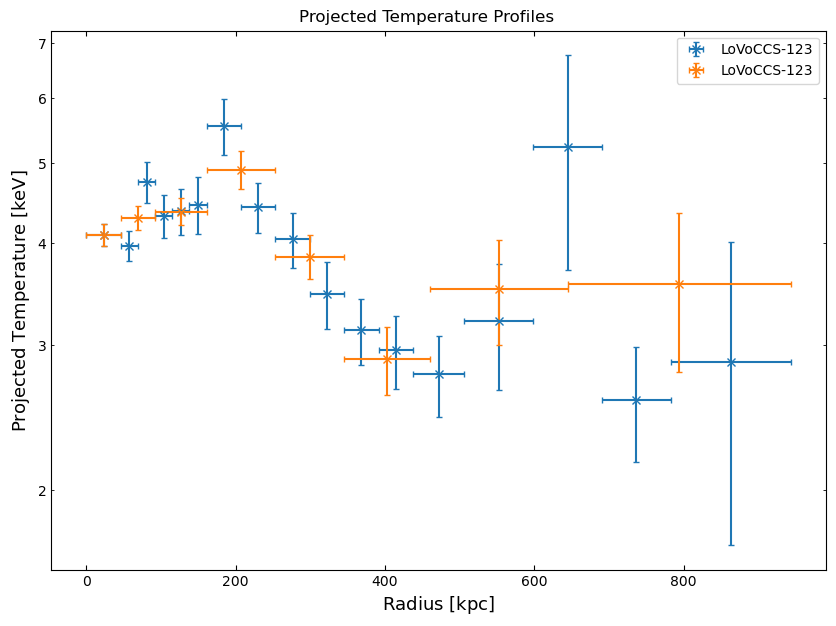

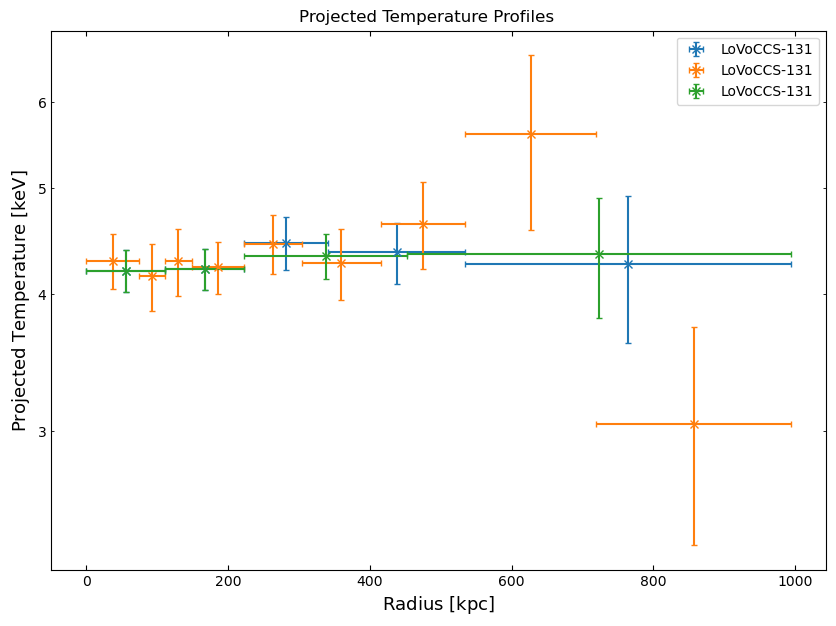

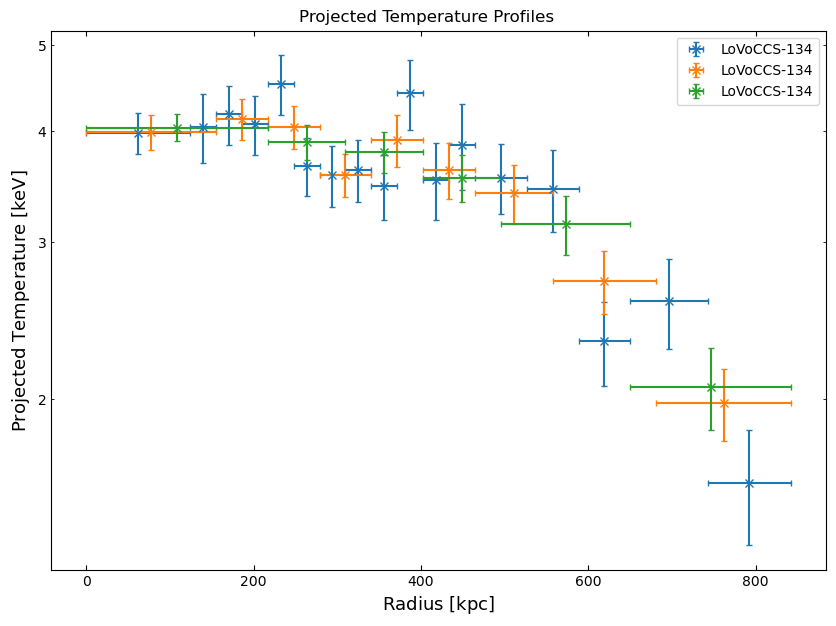

42

In [54]:
got_pt = 0
for src in srcs:
    try:
        pt = src.get_proj_temp_profiles()
        got_pt += 1
        file_name = "{n}_tproj_toR500.pdf".format(n=src.name)
        if isinstance(pt, list):
            pt = BaseAggregateProfile1D(pt)
            pt.view(xscale='linear', axis_formatters=forms, save_path=fig_dir + file_name)
        else:
            pt.view(xscale='linear', axis_formatters=forms)
            pt.save_view(fig_dir + file_name, xscale='linear', axis_formatters=forms)
        
    except NoProductAvailableError:
        print(src.name)
got_pt

### Projected Metallicity

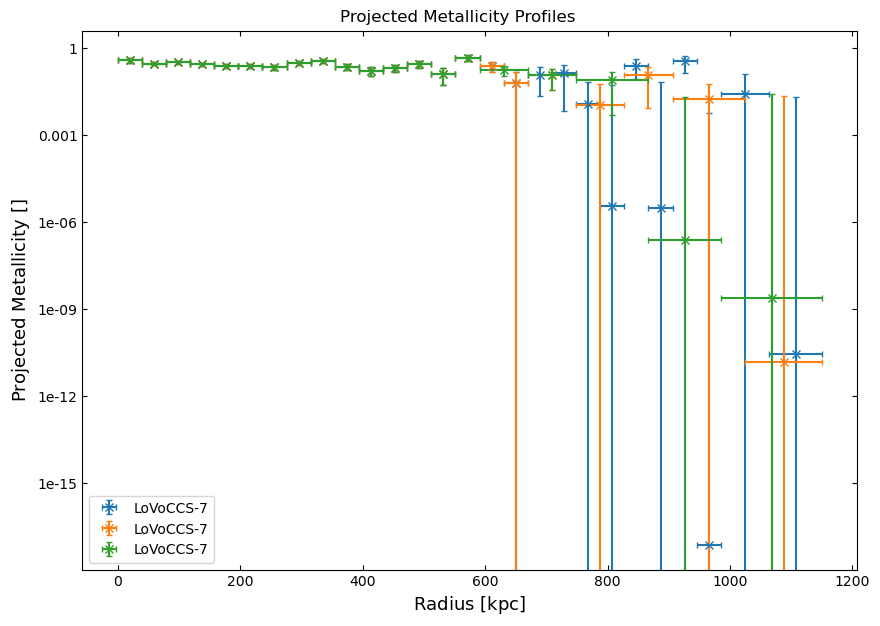

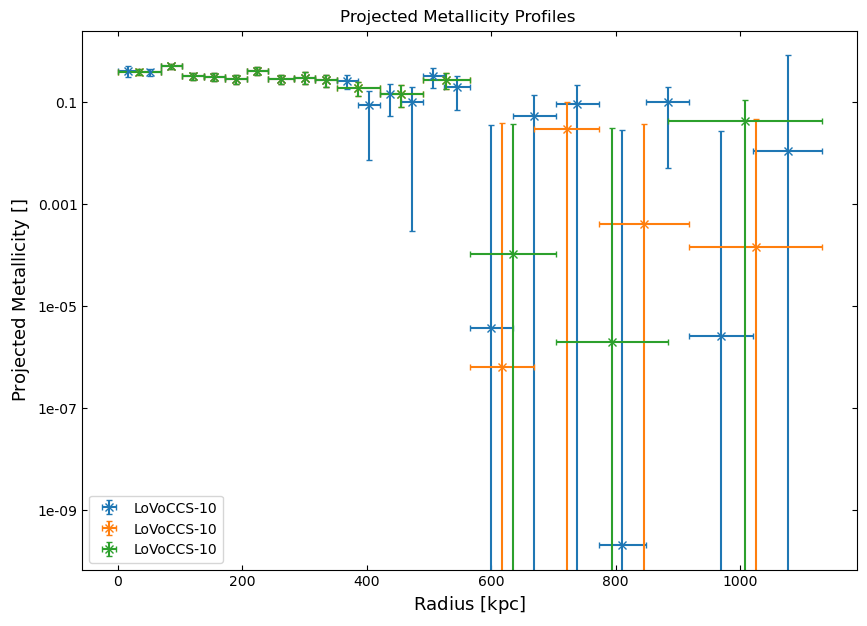

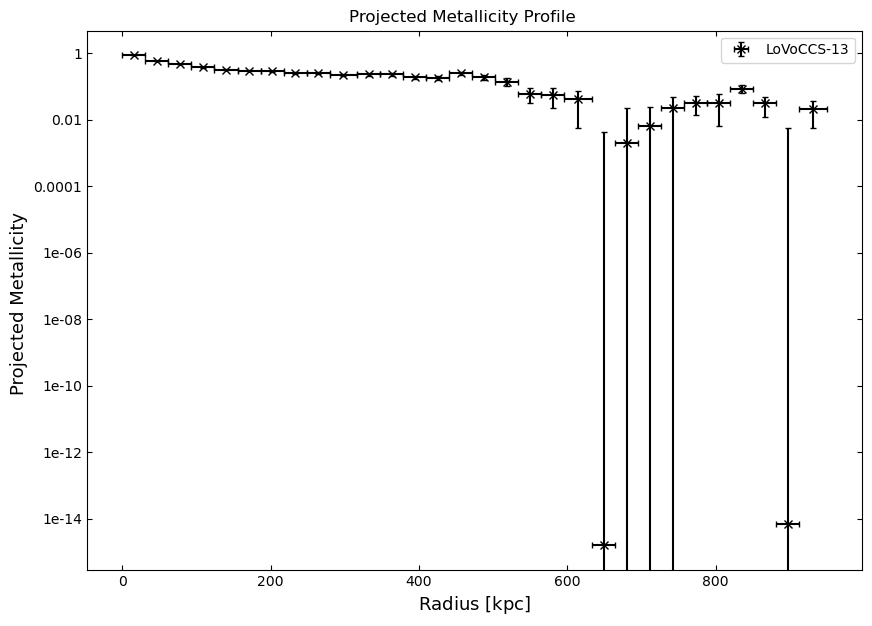

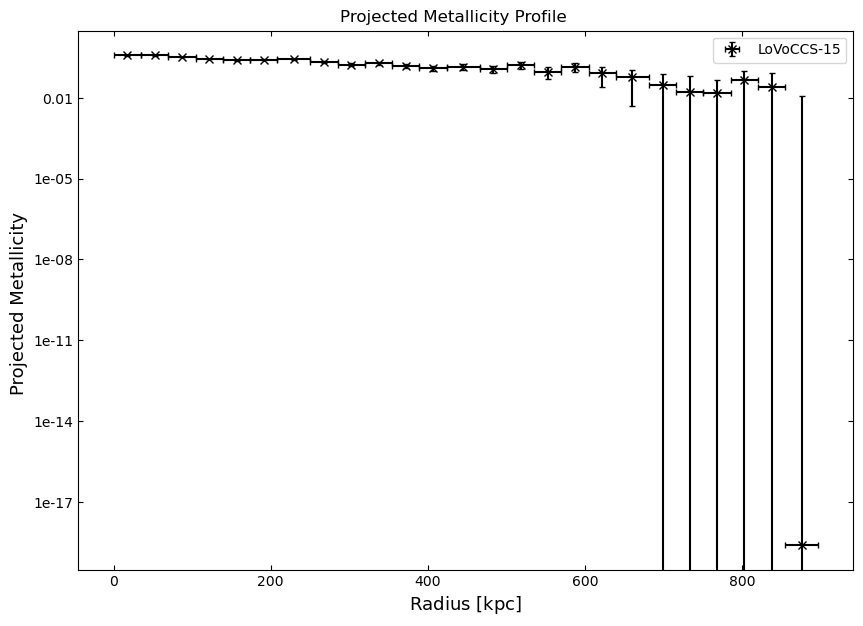

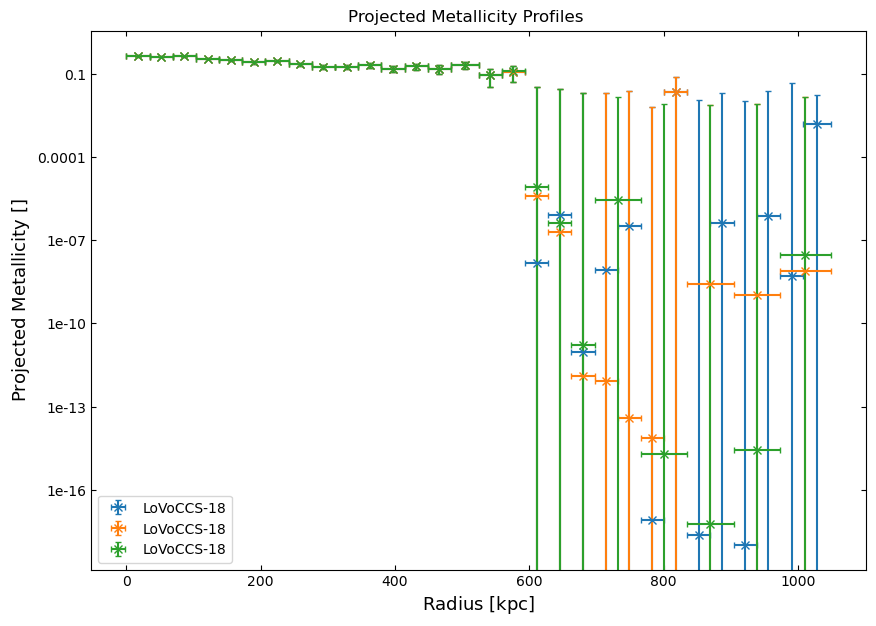

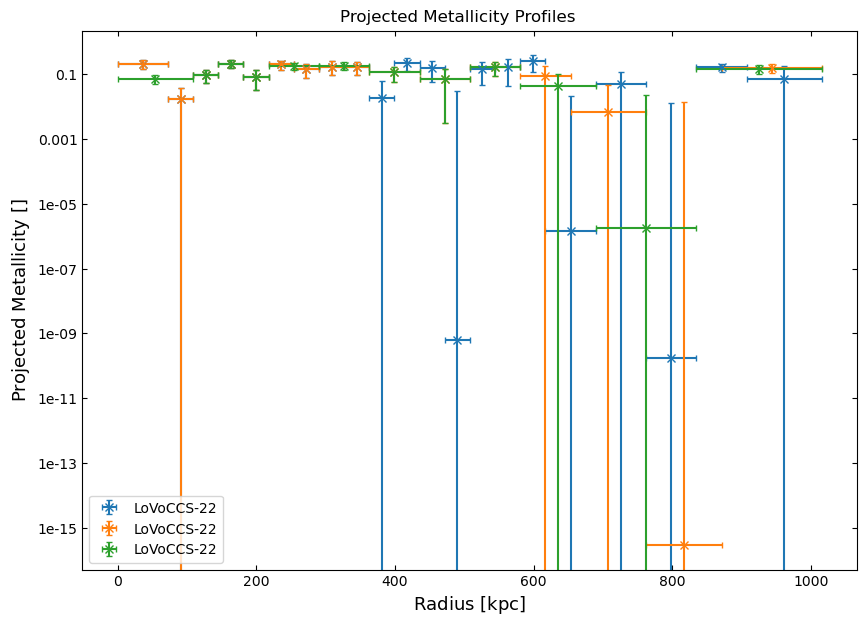

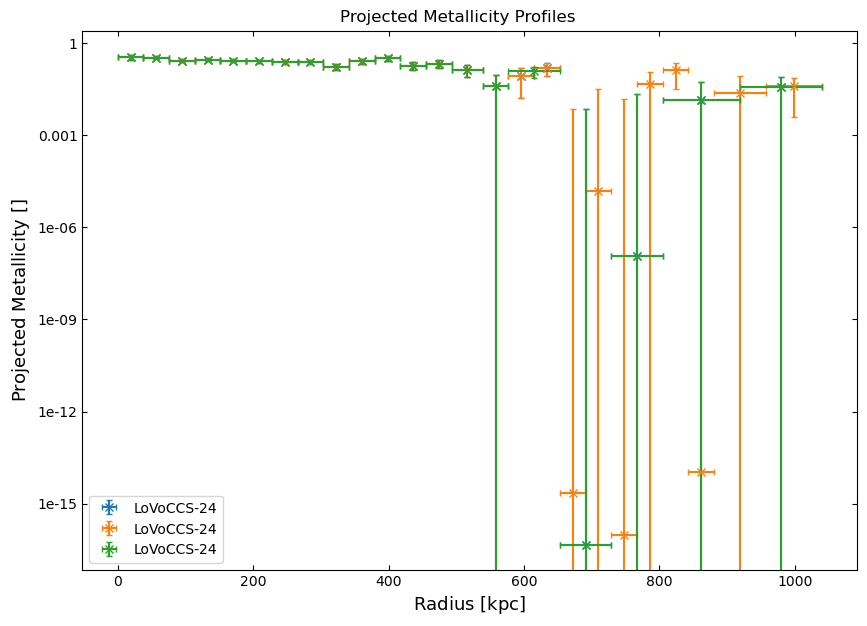

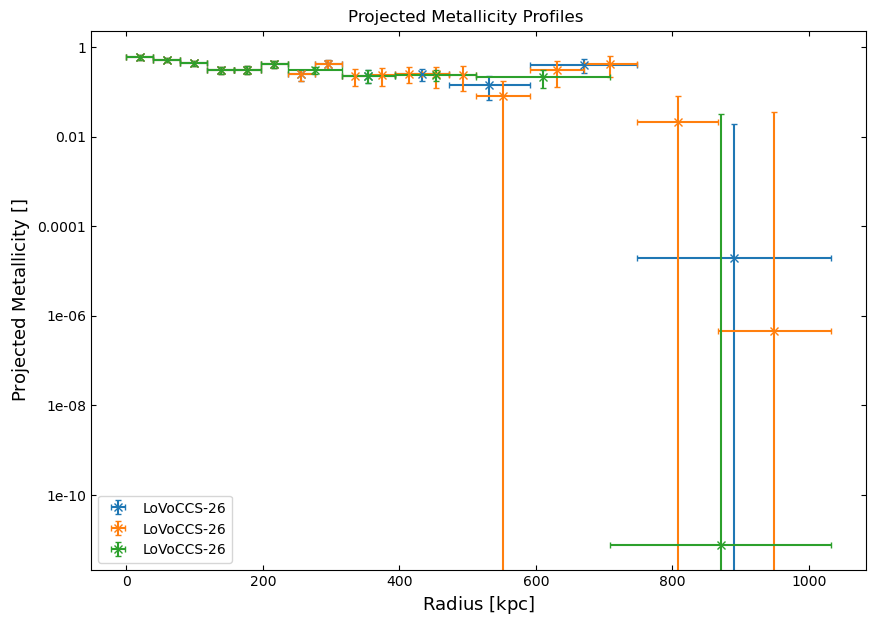

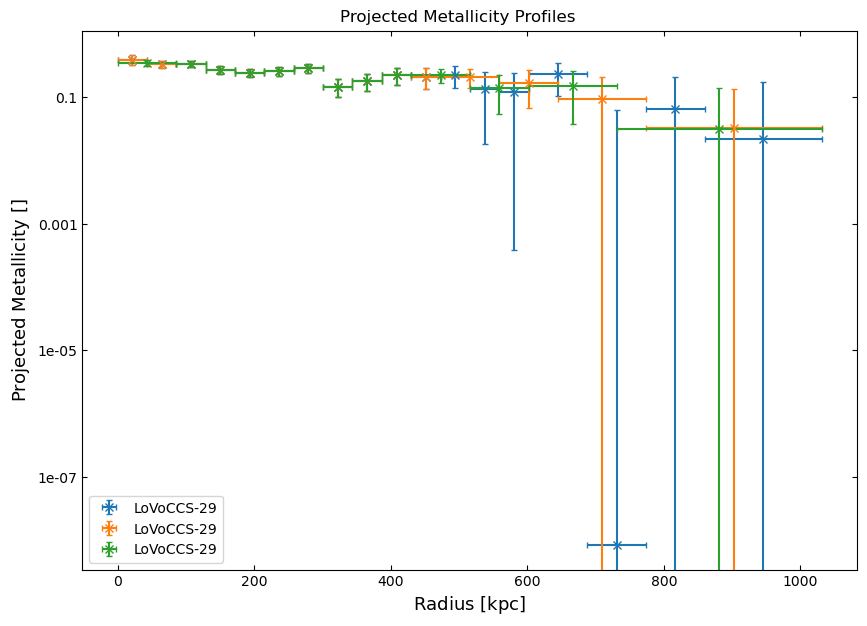

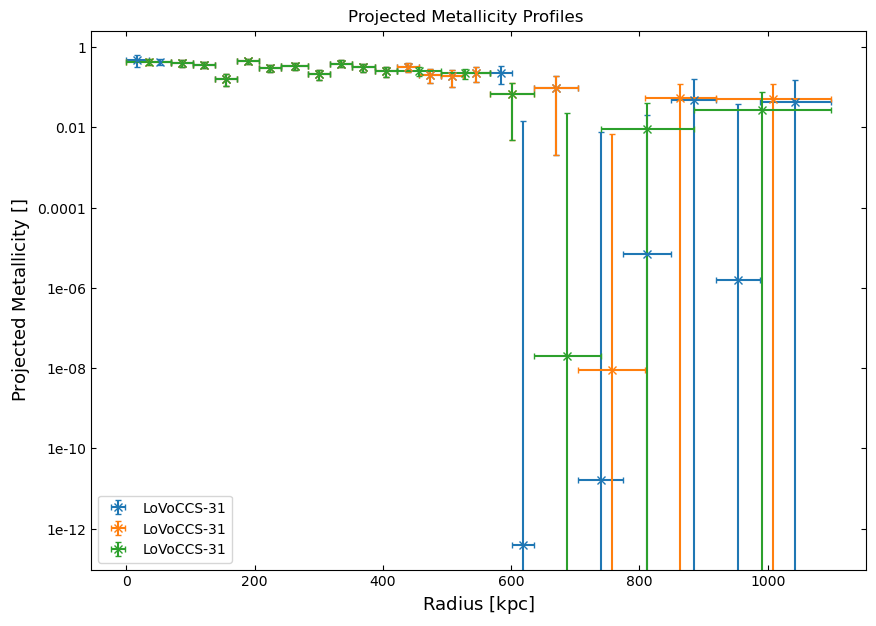

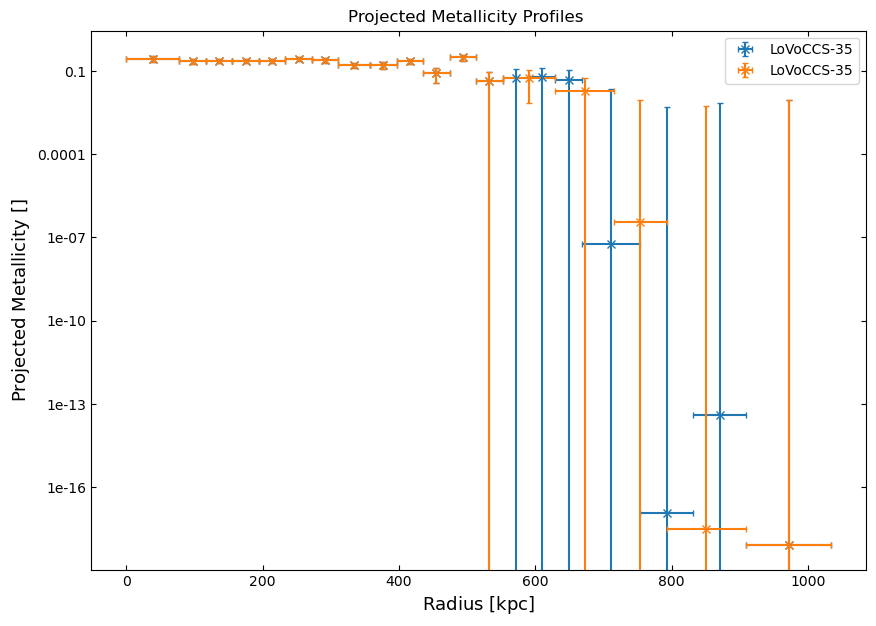

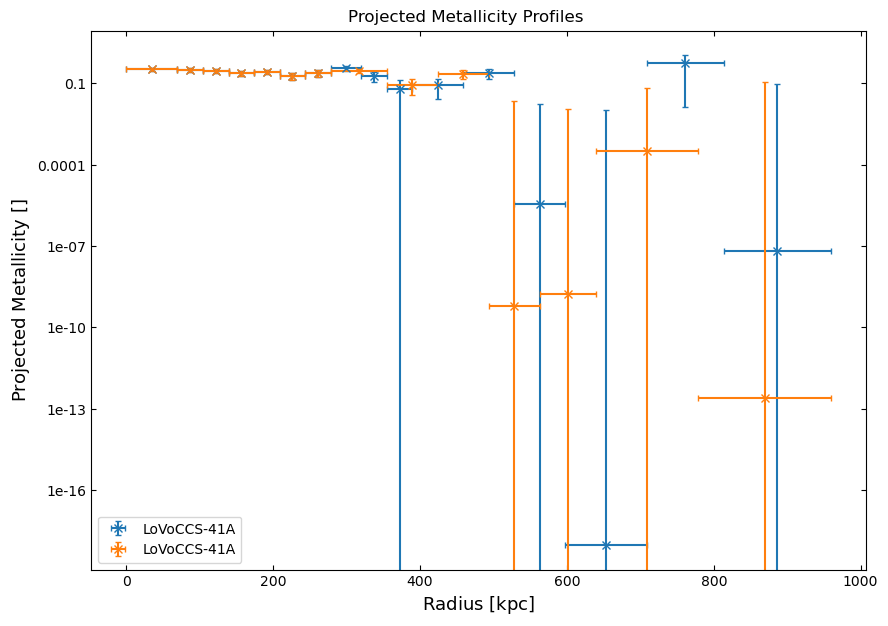

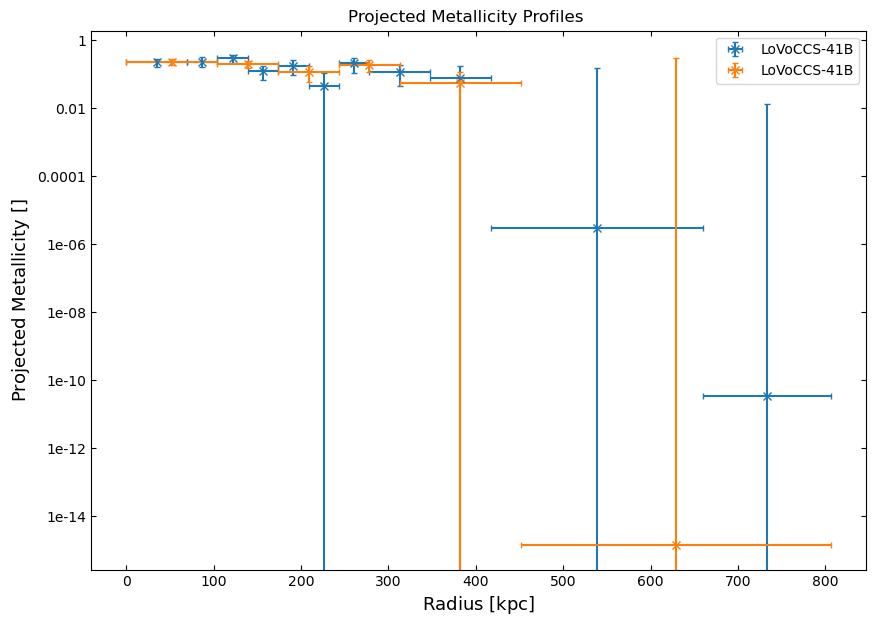

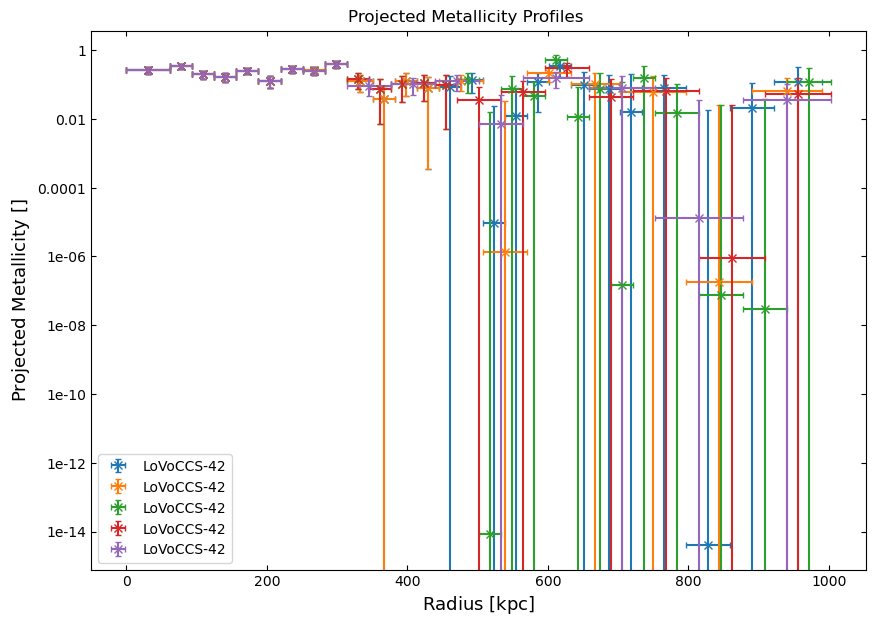

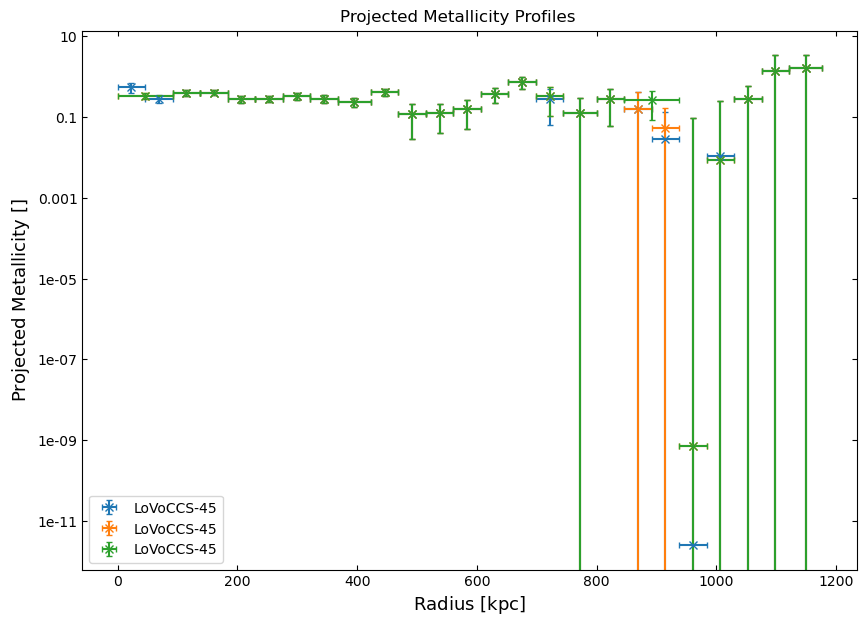

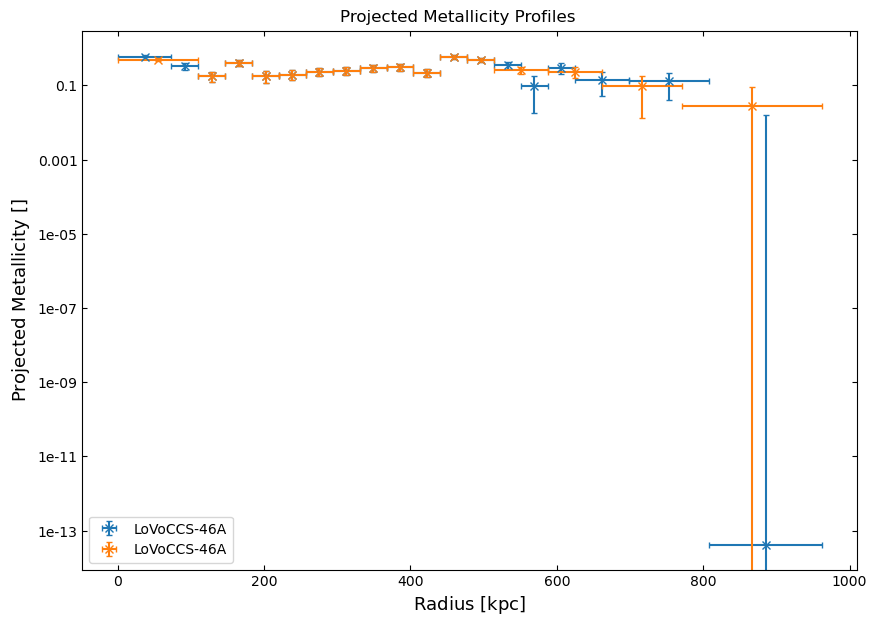

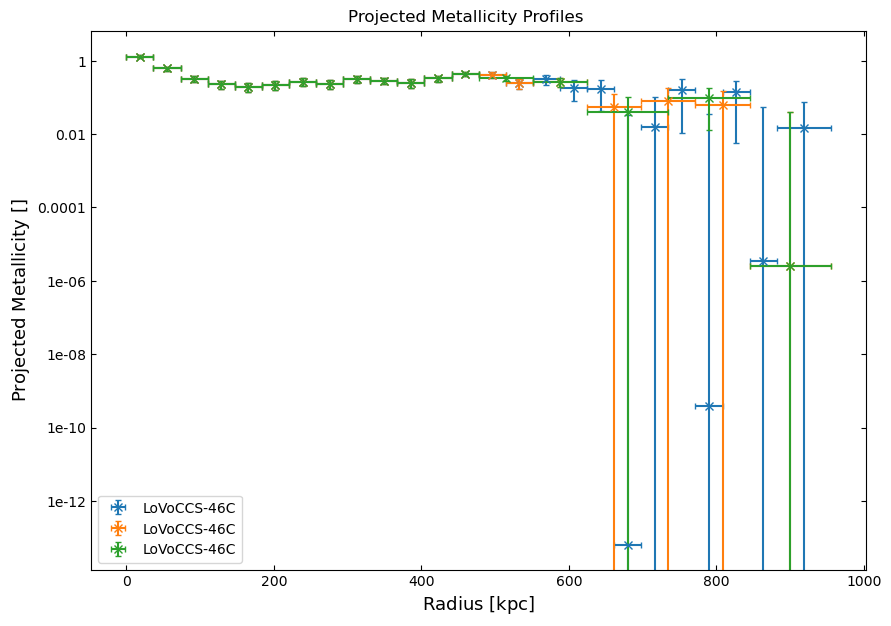

LoVoCCS-48A


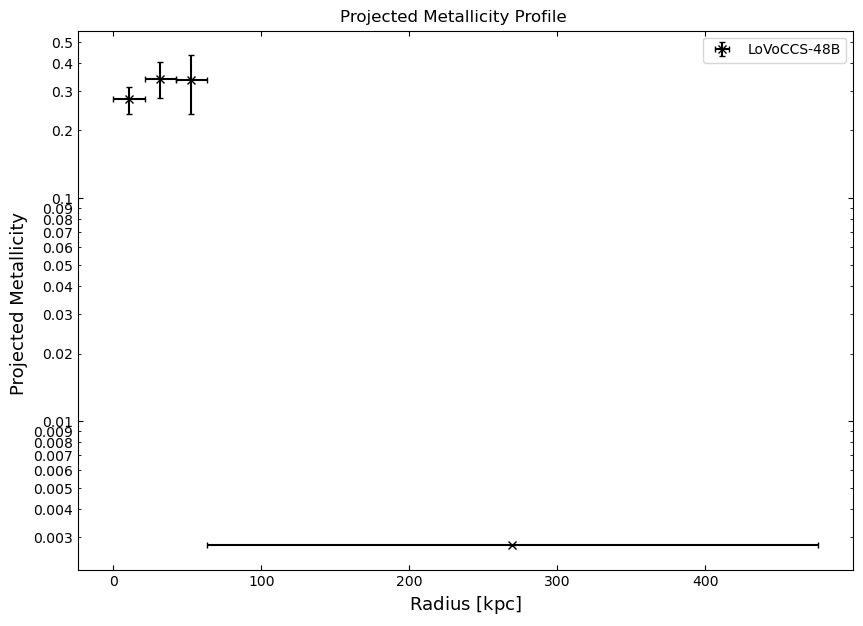

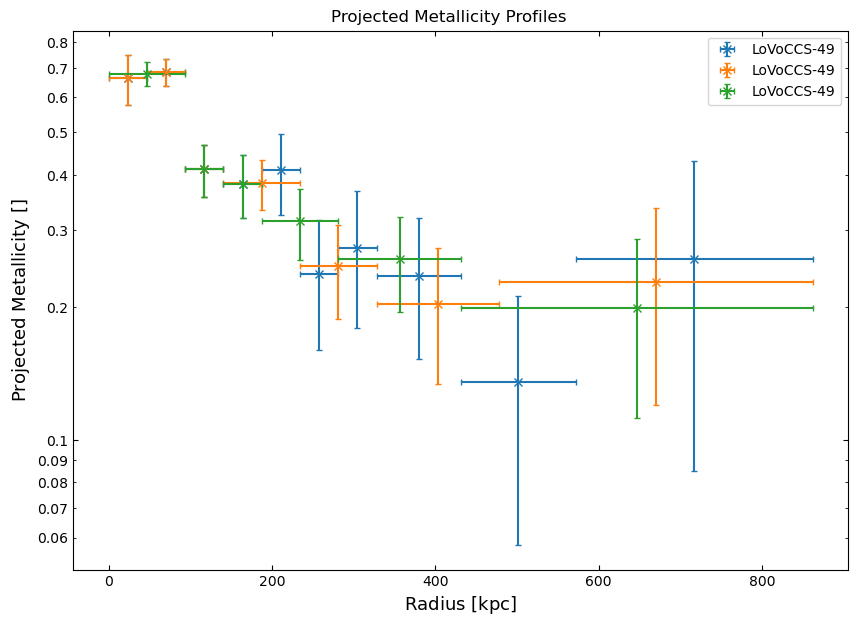

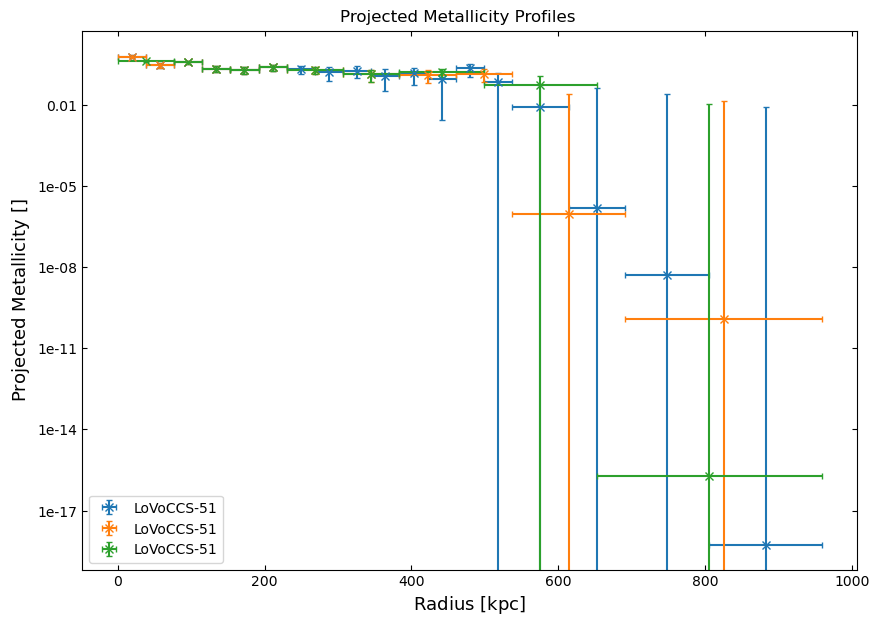

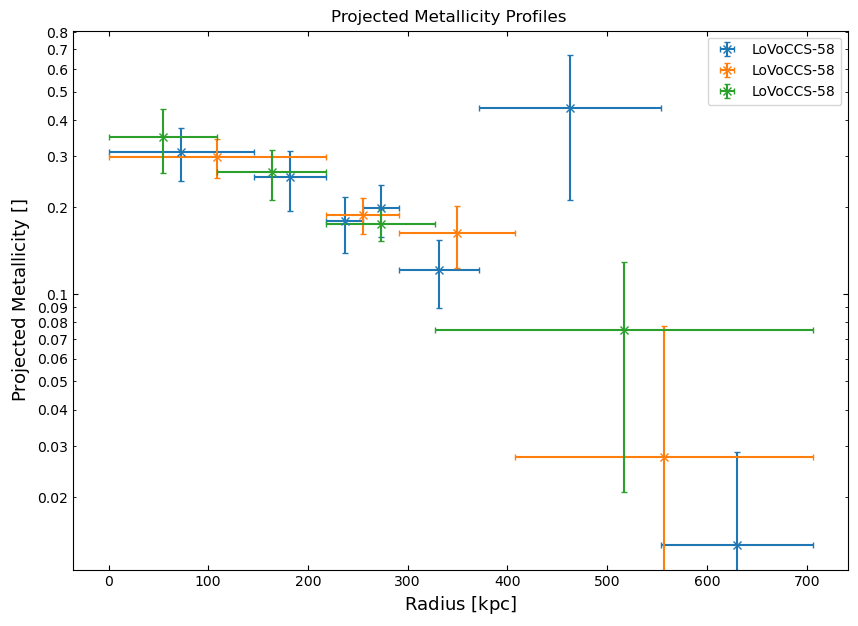

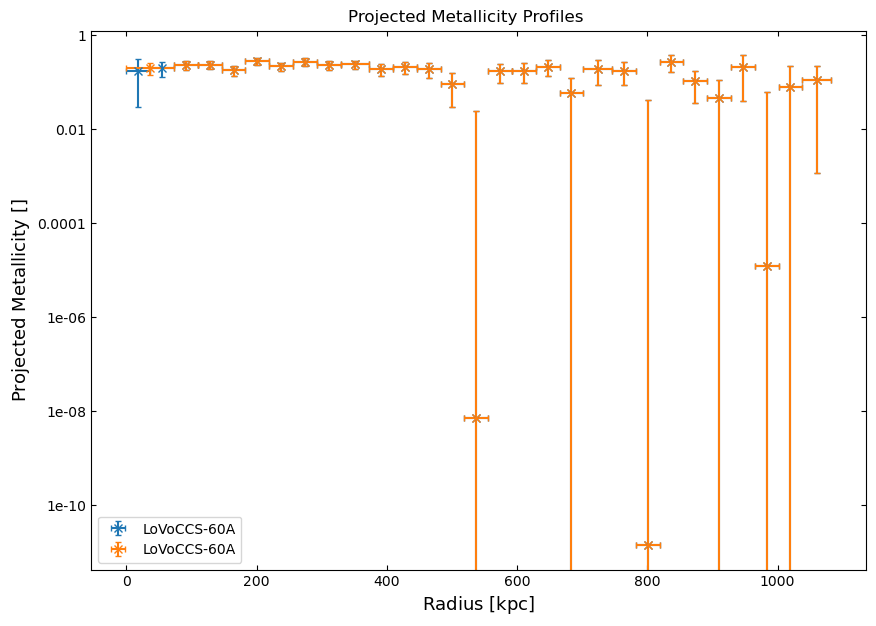

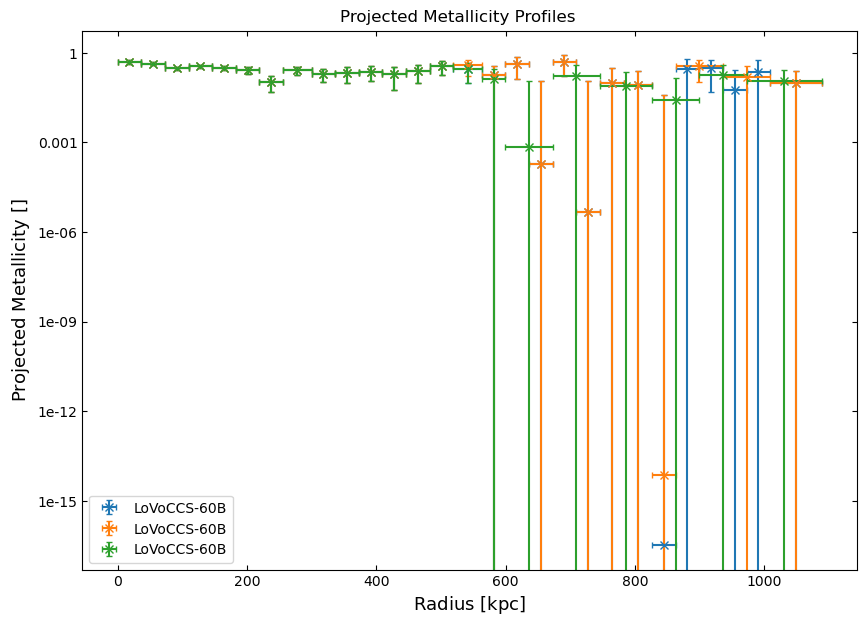

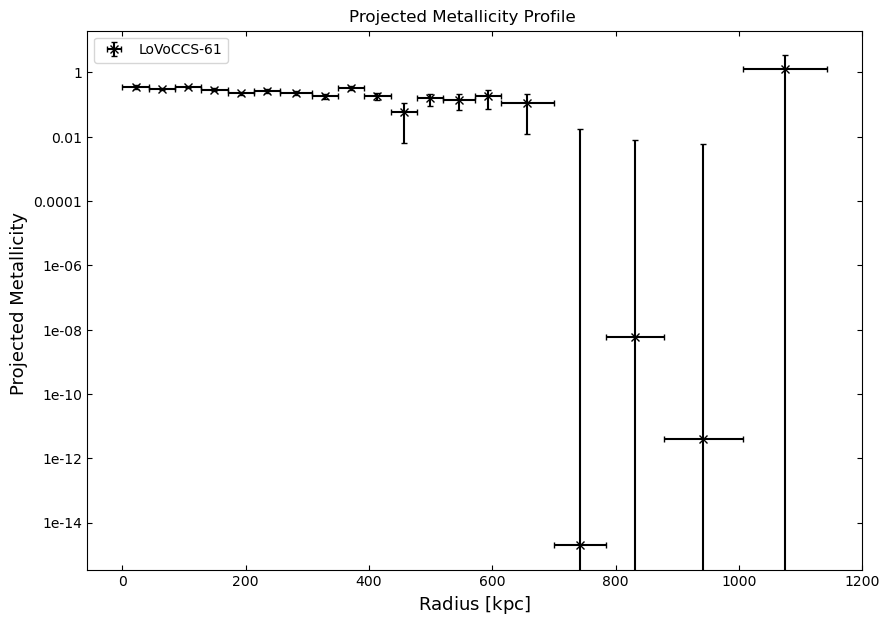

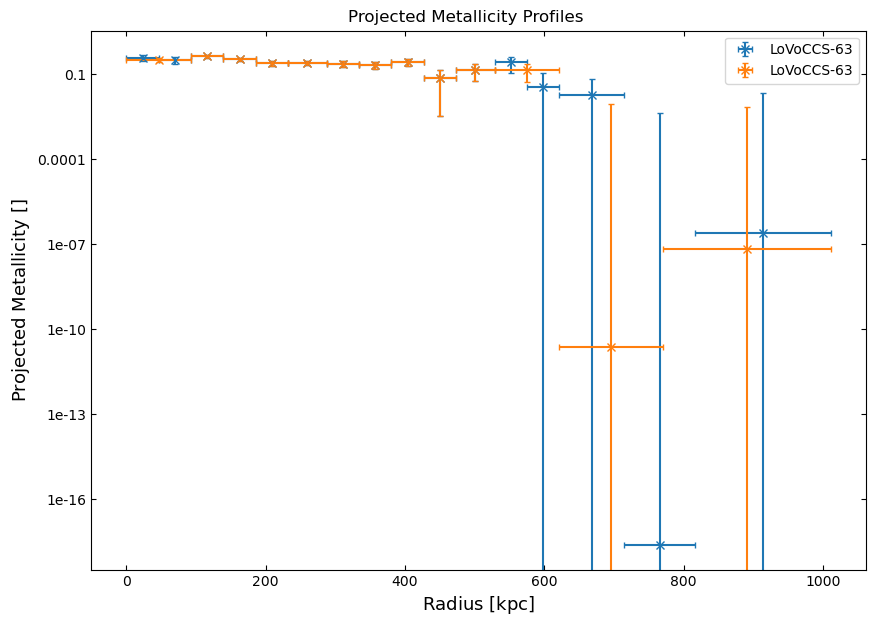

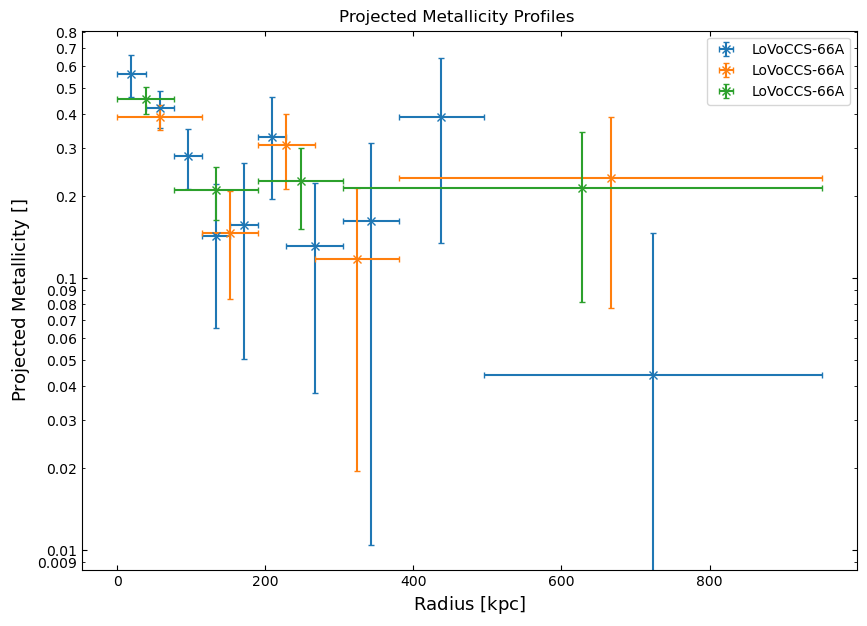

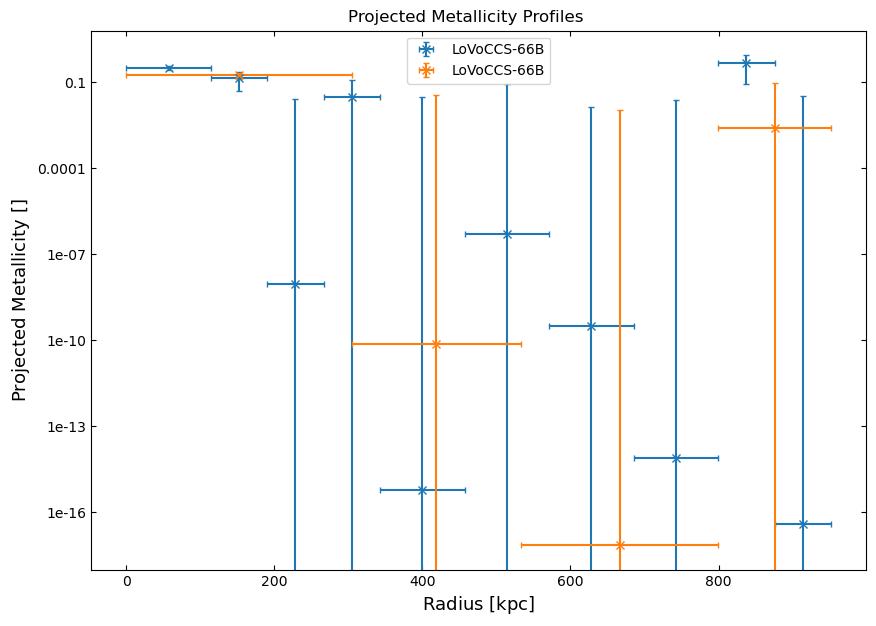

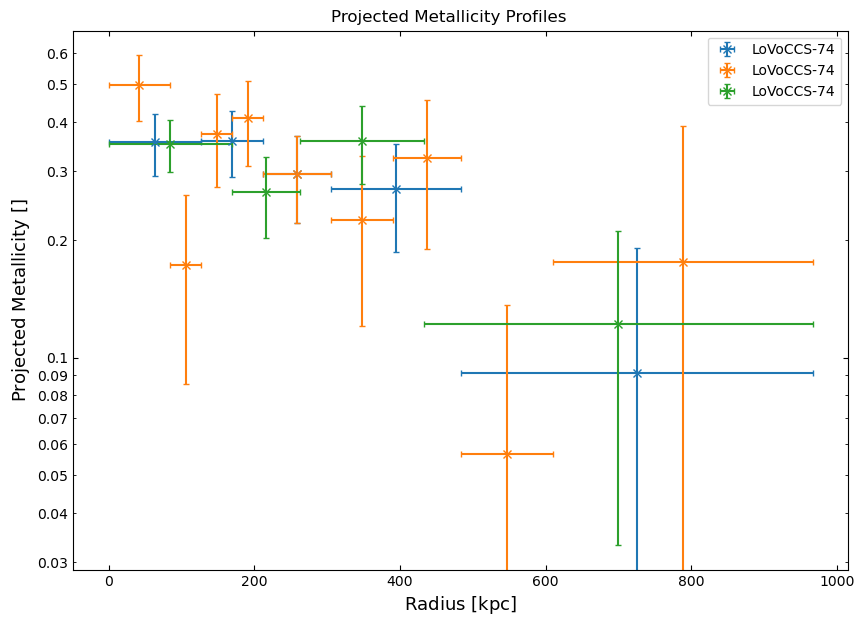

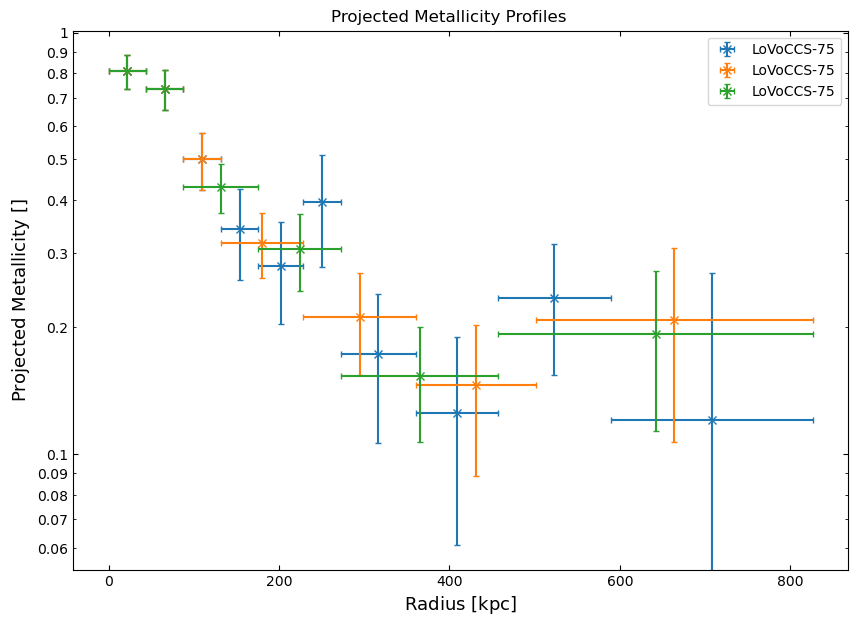

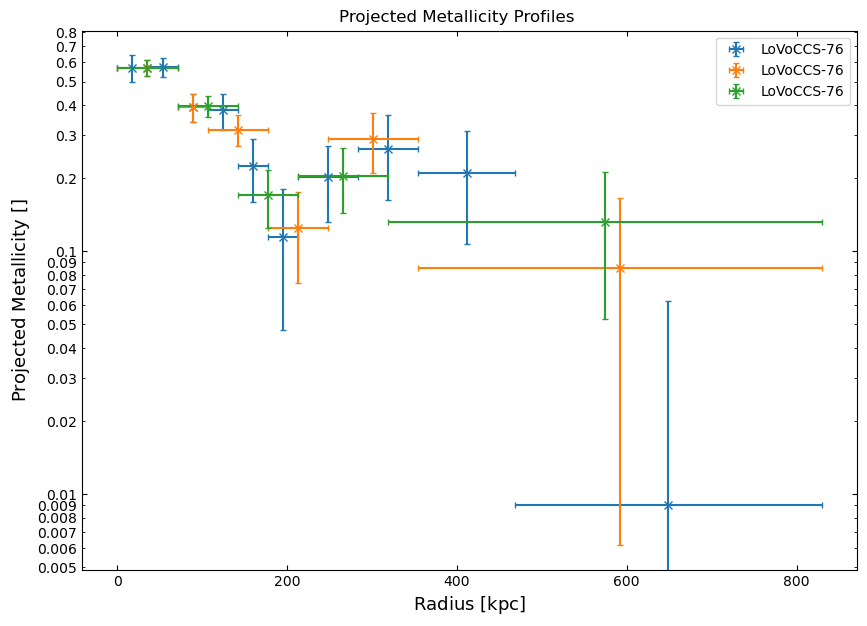

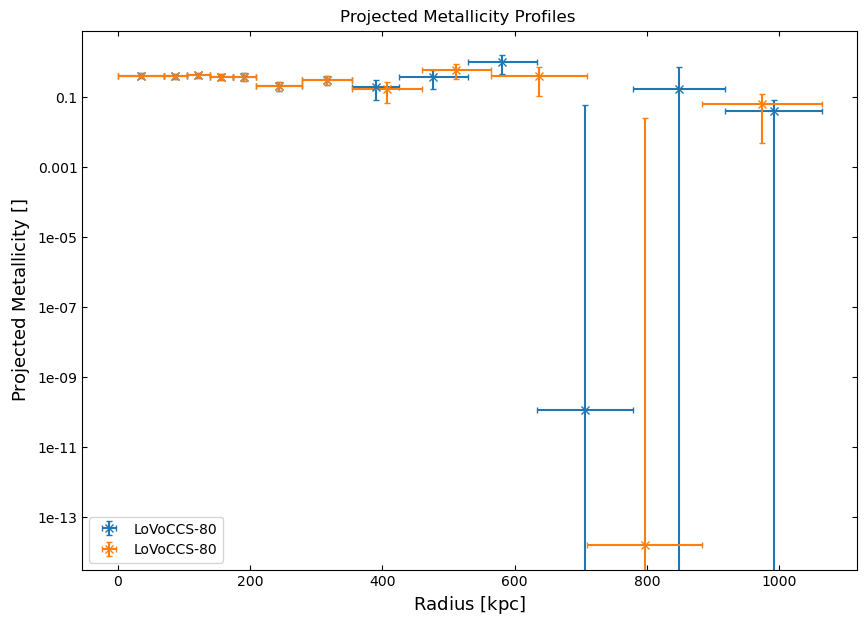

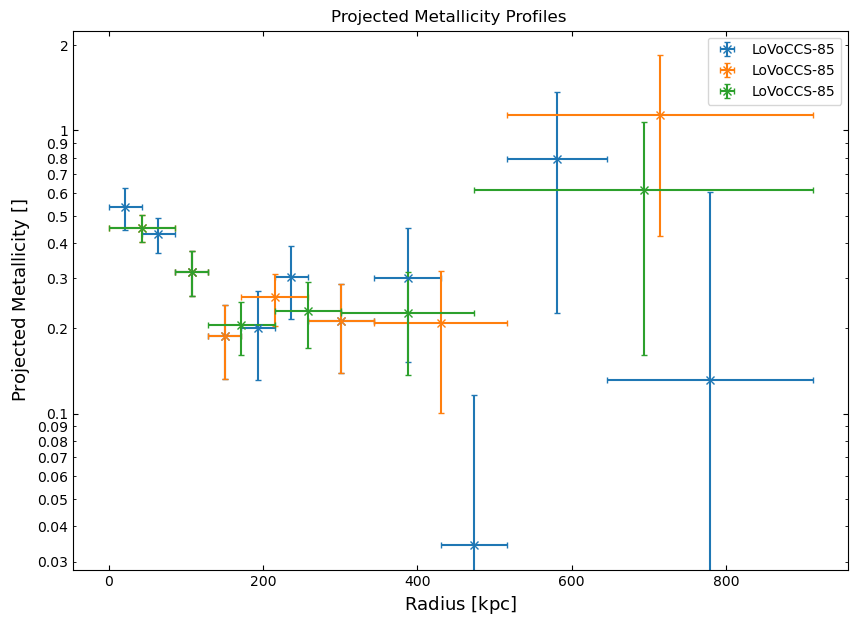

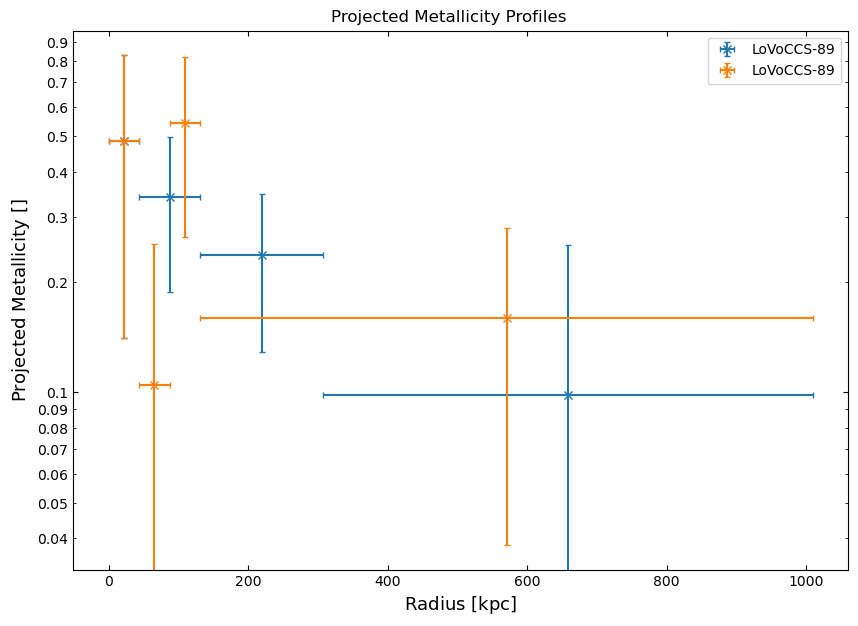

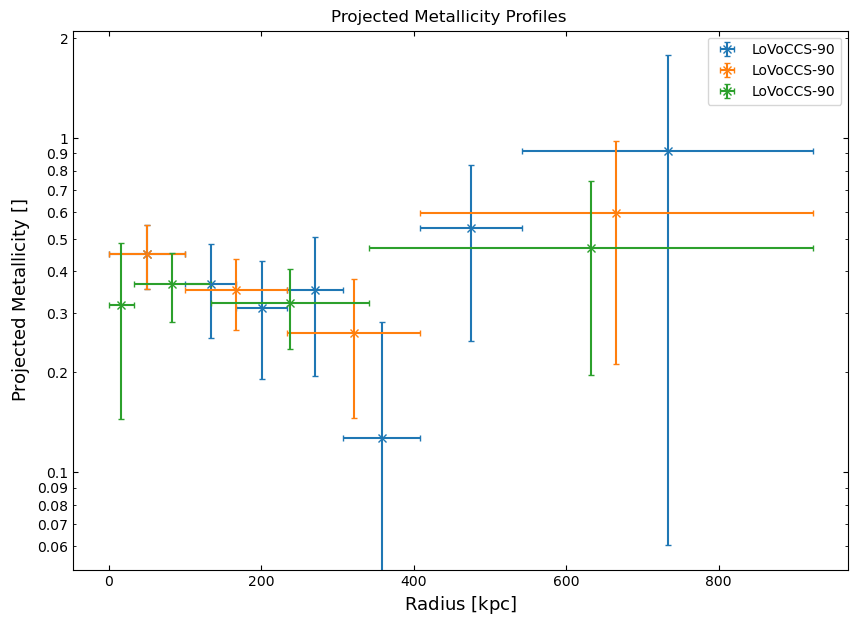

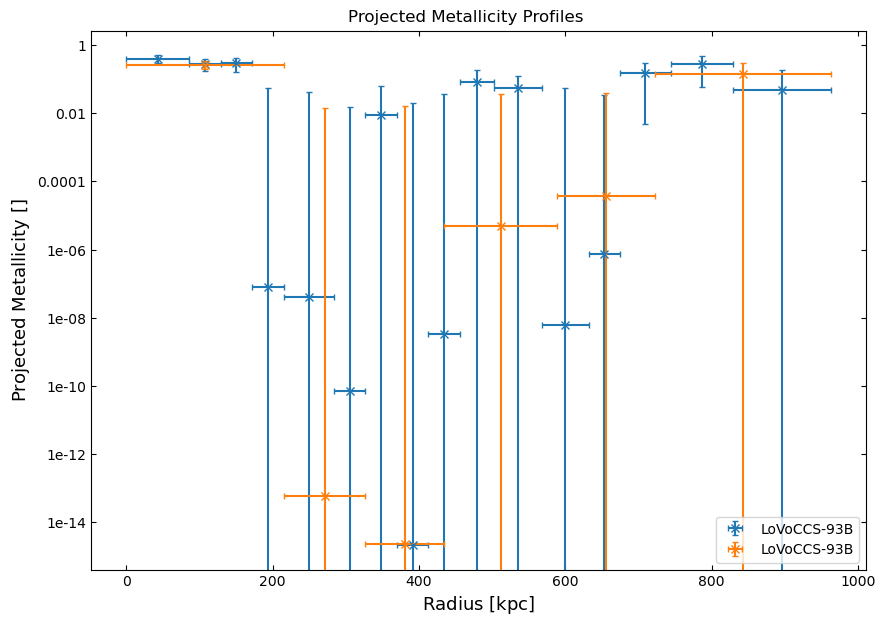

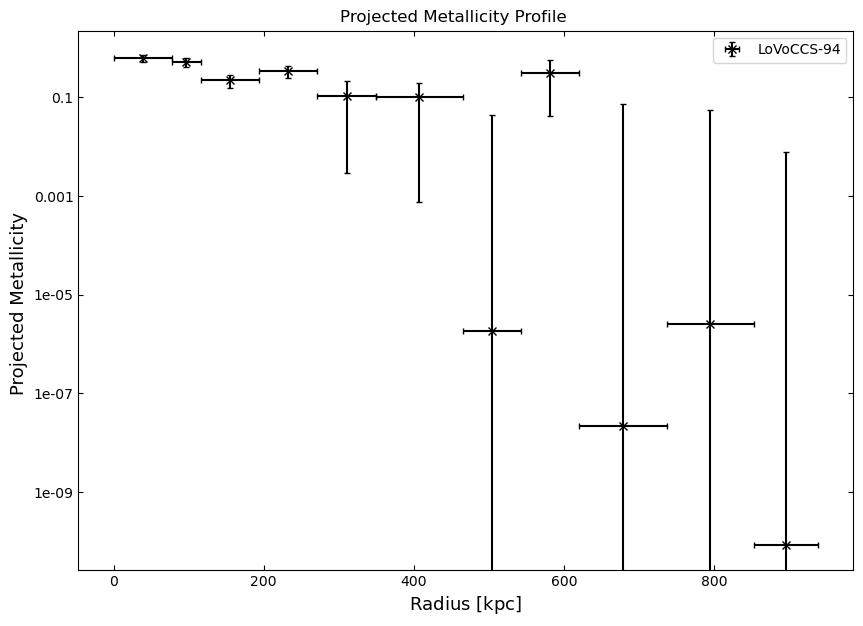

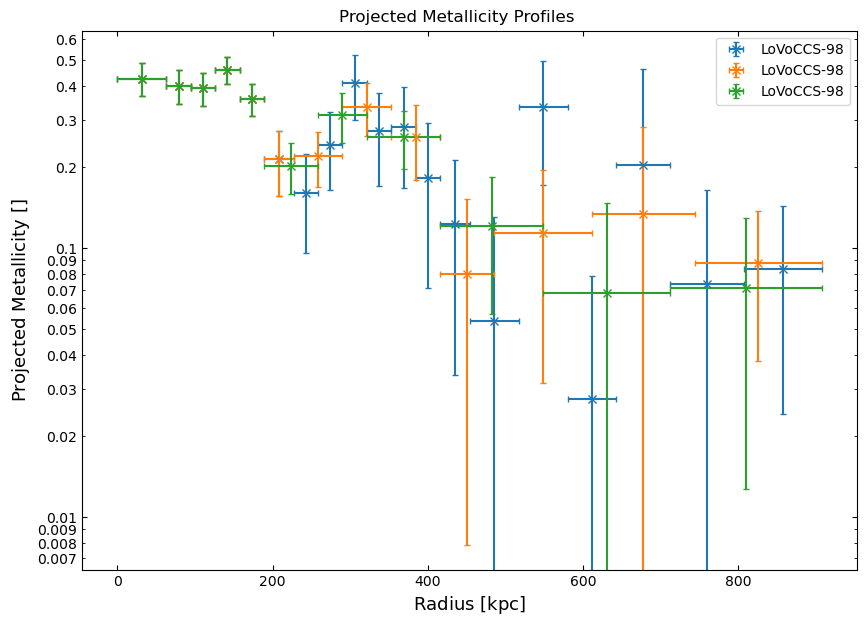

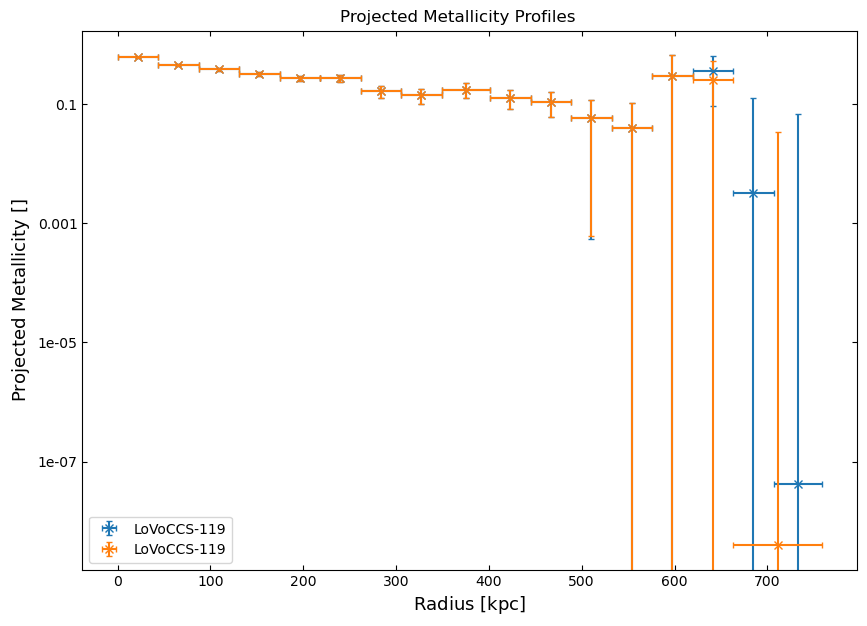

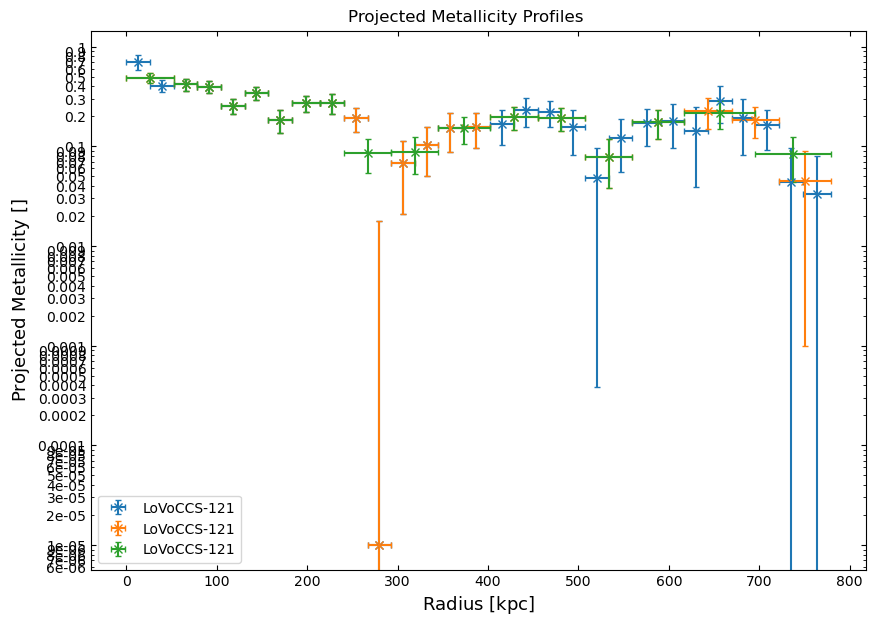

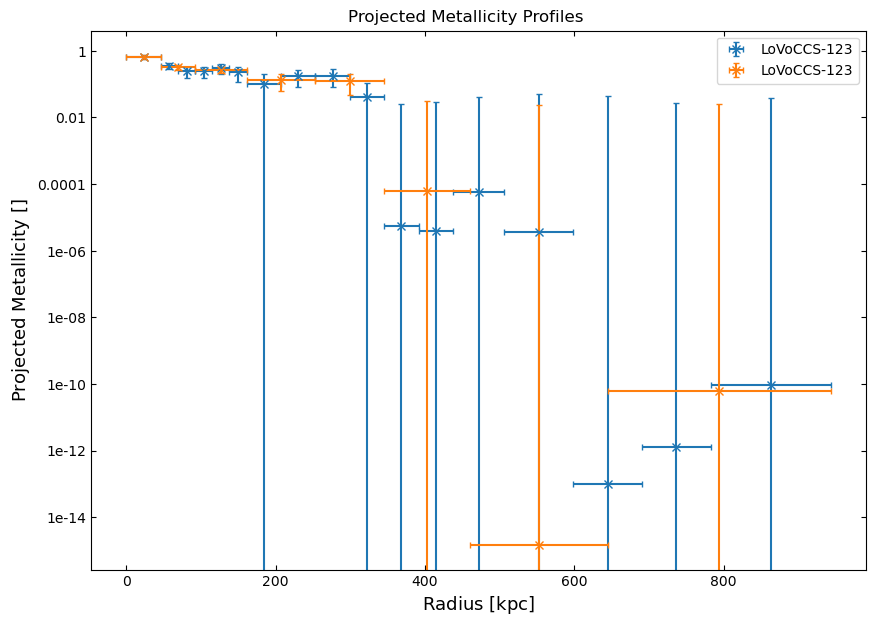

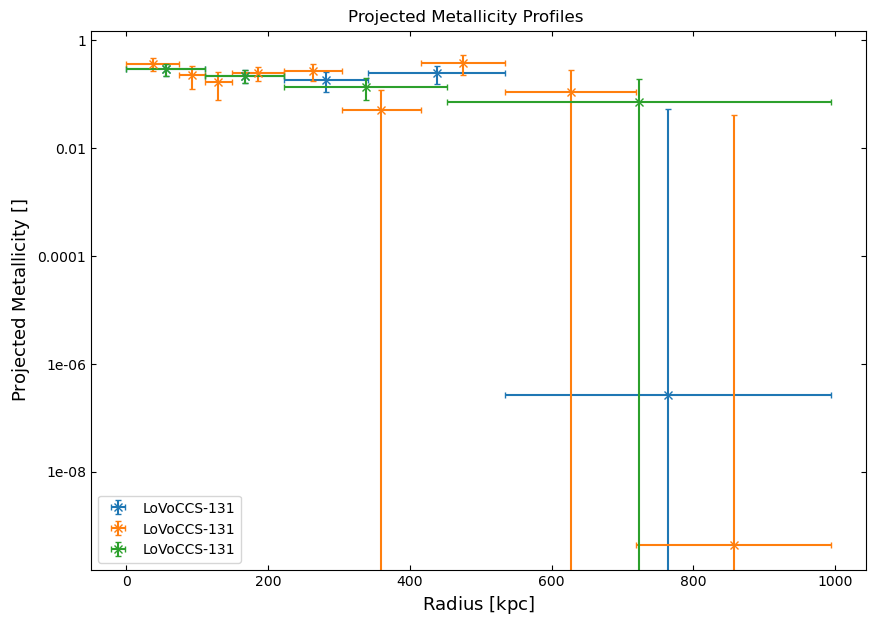

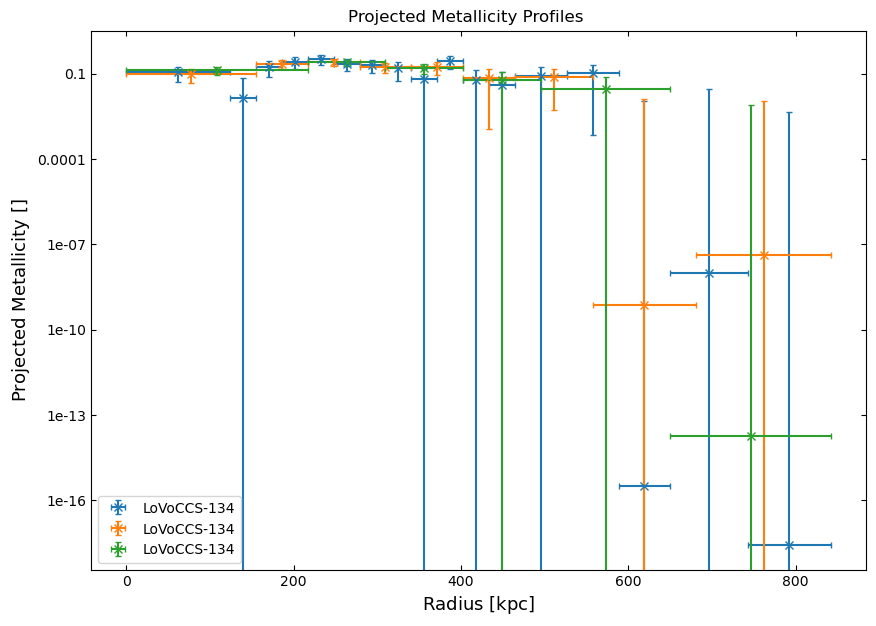

42

In [60]:
got_pm = 0
for src in srcs:
    try:
        pm = src.get_combined_profiles('1d_proj_metallicity')
        
        got_pm += 1        
        file_name = "{n}_metproj_toR500.pdf".format(n=src.name)
        if isinstance(pm, list):
            pm = BaseAggregateProfile1D(pm)
            pm.view(xscale='linear', axis_formatters=forms, save_path=fig_dir_met + file_name)
        else:
            pm.view(xscale='linear', axis_formatters=forms)
            pm.save_view(fig_dir_met + file_name, xscale='linear', axis_formatters=forms)
        
    except NoProductAvailableError:
        print(src.name)
got_pm